<a href="https://colab.research.google.com/github/eichhorn-lab/PTMmap2structure/blob/main/PTMmap2structure_v1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PTM map to structure notebook**
## *version 1.4, last updated 08/06/2024*
####*created by CD Eichhorn, 2024*
---

**Instructions:**
- To run, click Runtime tab, then run all.
- Go to "Import CSV file" section and upload csv file when upload button appears.
- Accession numbers must be UniProt accessions.
- If you run AF or Colabfold to generate additional pdb files, create a folder to output/libraries directory named colabfold_pdbs and upload pdb coordinate files with the format accessionnumber.pdb.


# **Install packages and upload csv file**

In [ ]:
#@title Install packages

# install biopython, tdqm for progress bar
!pip install biopython
!pip install tqdm

# Install Miniconda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!bash Miniconda3-py37_4.8.3-Linux-x86_64.sh -bfp /usr/local
!rm Miniconda3-py37_4.8.3-Linux-x86_64.sh

# Add conda executable to PATH
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

# Install DSSP using conda
!conda install -y -c salilab dssp

# Test DSSP installation
!dssp -h

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 3.8 MB/s eta 0:00:00
PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - ca-certificates==2020.1.1=0
    - certifi==2020.4.5.1=py37_0
    - cffi==1.14.0=py37he30daa8_1
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.1=py37h7b6447c_0
    - conda==4.8.3=py37_0
    - cryptography==2.9.2=py37h1ba5d50_0
    - idna==2.9=py_1
    - ld_impl_linux-64==2.33.1=h53a641e_7
    - libedit==3.1.20181209=hc058e9b_0
    - libffi==3.3=he6710b0_1
    - libgcc-ng==9.1.0=hdf63c60_0
    - libstdcxx-ng==9.1.0=hdf63c60_0
    - ncurses==6.2=he6710b0_1
    - openssl==1.1.1g=h7b6447c_0
    - pip==20.0.2=py37_3
    - pycosat==0.6.3=py37h7b6447c_0
    - pycparser==2.20=py_0
    - pyopenssl==19.1.0=py37_0
    - pysocks==1.7.1=py37_0
    - python==3.7.7=hcff3b4d_5
    - readline==8.0=h7b6447c_0
    - requ

In [ ]:
#@title Import packages
import csv
import os
import re
import matplotlib.font_manager
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import requests
import seaborn as sns  # Import seaborn for plotting
import shutil
import zipfile

from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.colab import files as colab_files
from google.colab import files
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from statsmodels.stats.weightstats import ttest_ind
from tqdm import tqdm


In [ ]:
#@title Import CSV file, separate into all, significant, and not significant data by p-value (0.05)

import os
import re
import csv
import pandas as pd

def sanitize_filename(filename):
    """Remove or replace characters that are invalid for file names and spaces."""
    invalid_chars = ['/', ':', '*', '?', '"', '<', '>', '|', '\\', ' ']
    for char in invalid_chars:
        filename = filename.replace(char, '_')
    return filename

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def classify_files(input_directory, output_directory, log_file):
    """Classifies files based on abundance P-value and writes to new files with 'sig_' or 'notsig_' prefix,
    and counts unique accession numbers for each output file."""
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Initialize DataFrame to store Gene ID and Accession Number pairs
    gene_id_accession_pairs = pd.DataFrame(columns=['Gene ID', 'Accession Number'])

    # List all TSV files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith(".tsv") and "modlist_Abundance_Ratio_(log2)" in filename:
            # Avoid reprocessing already processed files
            if filename.startswith("sig_") or filename.startswith("notsig_"):
                continue

            input_file_path = os.path.join(input_directory, filename)
            with open(input_file_path, mode='r') as file:
                reader = csv.reader(file, delimiter='\t')
                headers = next(reader)  # Assume first row is the header

                # Find the index for the 'Adj. P-Value' column and 'Accession' column
                try:
                    pvalue_index = headers.index('Adj. P-Value')
                    accession_index = headers.index('Accession Number')
                    gene_id_index = headers.index('Gene ID')
                except ValueError:
                    write_log(log_file, f"Required columns not found in {filename}")
                    continue

                sanitized_filename = sanitize_filename(filename)
                sig_output_path = os.path.join(output_directory, f"sig_{sanitized_filename[4:]}")
                notsig_output_path = os.path.join(output_directory, f"notsig_{sanitized_filename[4:]}")

                # Prepare to write to new files
                sig_writer = csv.writer(open(sig_output_path, 'w', newline=''), delimiter='\t')
                notsig_writer = csv.writer(open(notsig_output_path, 'w', newline=''), delimiter='\t')

                # Write headers to new files
                sig_writer.writerow(headers)
                notsig_writer.writerow(headers)

                # Initialize sets to track unique accession numbers
                unique_accessions_sig = set()
                unique_accessions_notsig = set()
                unique_accessions_no_modifications = set()

                # Counters for the number of rows written and modifications listed as "None"
                sig_rows_written = 0
                notsig_rows_written = 0
                sig_none_modifications = 0
                notsig_none_modifications = 0
                sig_modifications_count = 0
                notsig_modifications_count = 0

                # Iterate over each row in the original file
                for row in reader:
                    try:
                        abundance_pvalue = float(row[pvalue_index])
                        accession_number = row[accession_index]
                        gene_id = row[gene_id_index]
                        modifications = row[headers.index('Modifications')]

                        # Append Gene ID and Accession Number pair to DataFrame
                        gene_id_accession_pairs = pd.concat([gene_id_accession_pairs, pd.DataFrame([{'Gene ID': gene_id, 'Accession Number': accession_number}])], ignore_index=True)

                        # Track unique accession numbers with no letter or numerical values in modifications
                        if pd.isna(modifications) or not any(char.isalnum() for char in modifications):
                            unique_accessions_no_modifications.add(accession_number)

                        # Write row to the appropriate file based on P-value
                        if abundance_pvalue <= 0.05:
                            sig_writer.writerow(row)
                            unique_accessions_sig.add(accession_number)
                            sig_rows_written += 1
                            if modifications == 'None':
                                sig_none_modifications += 1
                            else:
                                sig_modifications_count += 1
                        else:
                            notsig_writer.writerow(row)
                            unique_accessions_notsig.add(accession_number)
                            notsig_rows_written += 1
                            if modifications == 'None':
                                notsig_none_modifications += 1
                            else:
                                notsig_modifications_count += 1
                    except ValueError:
                        # Handle cases where conversion to float fails
                        write_log(log_file, f"Error processing line in {filename}: {row}")
                        continue

                # Print the number of unique accession numbers and modifications for each file
                write_log(log_file, f"{len(unique_accessions_sig)} Total unique accession numbers with {sig_modifications_count} modifications (excluding {sig_none_modifications} listed as 'None') in {sig_output_path}")
                write_log(log_file, f"{len(unique_accessions_notsig)} Total unique accession numbers with {notsig_modifications_count} modifications (excluding {notsig_none_modifications} listed as 'None') in {notsig_output_path}")

    # Identify Gene IDs with multiple different Accession Numbers
    gene_id_counts = gene_id_accession_pairs.groupby('Gene ID')['Accession Number'].nunique()
    isoform_gene_ids = gene_id_counts[gene_id_counts > 1].index

    # Filter the isoform data for exact matches of gene ids
    isoform_data = gene_id_accession_pairs[gene_id_accession_pairs['Gene ID'].isin(isoform_gene_ids)]
    isoform_data = isoform_data.drop_duplicates()

    # Pivot the table to list each Gene ID with all its accession numbers in a single row
    isoform_pivot = isoform_data.groupby('Gene ID')['Accession Number'].apply(lambda x: ' '.join(x.unique())).reset_index()

    # Create and save the output file for phosphoprotein isoforms
    phosphoprotein_isoforms_path = os.path.join(output_directory, 'phosphoprotein_isoforms.tsv')
    isoform_pivot.to_csv(phosphoprotein_isoforms_path, sep='\t', header=True, index=False)
    write_log(log_file, f"Phosphoprotein isoforms with different accession numbers saved to {phosphoprotein_isoforms_path} ({len(isoform_gene_ids)} isoforms)")

def process_files():
    # Specify the input and output directories
    input_directory = "/content/input"
    output_directory = "/content/output/modlist_files"
    logs_directory = os.path.join("/content/output/logs")

    # Ensure the directories exist
    os.makedirs(input_directory, exist_ok=True)
    os.makedirs(output_directory, exist_ok=True)
    os.makedirs(logs_directory, exist_ok=True)

    # File upload
    print("Please upload the data file:")
    uploaded_files = files.upload()

    # Process each uploaded CSV file
    for uploaded_file_name in uploaded_files.keys():
        # Define the input file path in the new input directory
        input_file_path = os.path.join(input_directory, uploaded_file_name)
        log_file = os.path.join(logs_directory, f"{os.path.splitext(uploaded_file_name)[0]}.log")

        # Save the uploaded file to the new input directory
        with open(input_file_path, 'wb') as f:
            f.write(uploaded_files[uploaded_file_name])

        # Read the uploaded file into a DataFrame
        data_df = pd.read_csv(input_file_path)

        # Find all columns that include 'Abundance Ratio (log2)' and 'Abundance Ratio Adj. P-Value'
        abundance_log2_columns = [col for col in data_df.columns if "Abundance Ratio (log2)" in col]
        abundance_pvalue_columns = [col for col in data_df.columns if col.startswith("Abundance Ratio Adj. P-Value")]

        # Check if the number of 'Abundance Ratio (log2)' and 'Abundance Ratio Adj. P-Value' columns match
        if len(abundance_log2_columns) != len(abundance_pvalue_columns):
            write_log(log_file, "The number of 'Abundance Ratio (log2)' and 'Abundance Ratio Adj. P-Value' columns do not match.")
            continue

        # Count rows with valid data (valid accession numbers)
        valid_data_df = data_df.dropna(subset=['Accession'])
        valid_rows_count = valid_data_df.shape[0]

        # Count duplicate accession numbers in the input CSV file
        duplicate_accessions_count = valid_data_df['Accession'].duplicated().sum()

        # Count the number of accession numbers with no modifications
        no_modifications_count = valid_data_df[valid_data_df['Modifications'].apply(lambda x: pd.isna(x) or not any(char.isalnum() for char in str(x)))].shape[0]

        # Count the total number of accession numbers with modifications
        total_accessionmods_count = valid_data_df[valid_data_df['Modifications'].apply(lambda x: not pd.isna(x) and x.strip() not in ['', 'None'])].shape[0]

        # Print the general statistics once
        write_log(log_file, f"Input CSV file: {valid_rows_count} rows containing data, {duplicate_accessions_count} duplicate accession numbers, {no_modifications_count} accession numbers with no modifications.")

        # Track modification types
        modification_types_count = {
            "Serine": 0,
            "Threonine": 0,
            "Tyrosine": 0,
            "Met-loss [N-term]": 0,
            "Met-loss+Acetyl [N-term]": 0
        }
        total_modifications_count = 0
        total_rows_with_modifications = 0

        # Iterate over each row in the input data to count modifications
        for index, row in valid_data_df.iterrows():
            modifications = 'None' if pd.isna(row['Modifications']) else row['Modifications']

            # Skip rows without modifications
            if modifications == 'None' or modifications.strip() == '':
                continue

            total_rows_with_modifications += 1

            # Extract all modifications, including those in nested parentheses
            modification_matches = re.findall(r'\b[S,T,Y]\d+\b', str(modifications))
            met_loss_match = re.findall(r'Met-loss\b', str(modifications))
            met_loss_acetyl_match = re.findall(r'Met-loss\+Acetyl\b', str(modifications))

            # Count modification types
            for match in modification_matches:
                aa = match[0]
                if aa == "S":
                    modification_types_count["Serine"] += 1
                elif aa == "T":
                    modification_types_count["Threonine"] += 1
                elif aa == "Y":
                    modification_types_count["Tyrosine"] += 1

            # Ensure Met-loss is counted only once per row
            if met_loss_match:
                modification_types_count["Met-loss [N-term]"] += 1
            if met_loss_acetyl_match:
                modification_types_count["Met-loss+Acetyl [N-term]"] += 1

            # Combine all matches into a single list
            all_matches = modification_matches
            if met_loss_match:
                all_matches.append('Met-loss [N-term]')
            if met_loss_acetyl_match:
                all_matches.append('Met-loss+Acetyl [N-term]')
            all_matches = all_matches if all_matches else ['None']

            total_modifications_count += len(all_matches)

        # Log detailed modification information
        modification_types_info = ', '.join([f"{count} {mod_type}" for mod_type, count in modification_types_count.items()])
        write_log(log_file, f"{total_accessionmods_count} accession numbers with {total_modifications_count} modifications: {modification_types_info}")

        # Verify that the total count of modifications matches the sum of individual types
        total_individual_modifications = sum(modification_types_count.values())
        if total_modifications_count != total_individual_modifications:
            write_log(log_file, f"Discrepancy found! Total modifications counted: {total_modifications_count}, Sum of individual types: {total_individual_modifications}")
            write_log(log_file, f"Number of rows with modifications: {total_rows_with_modifications}")

        # Process each pair of 'Abundance Ratio (log2)' and 'Abundance Ratio Adj. P-Value' columns
        for log2_col, pvalue_col in zip(abundance_log2_columns, abundance_pvalue_columns):
            all_rows_list = []  # Initialize the list for this specific pair of columns
            significant_modifications_count = 0
            unique_accessions_no_modifications_set = set()  # To track unique accession numbers with no modifications
            sanitized_column_name = sanitize_filename(log2_col)
            output_file_path = os.path.join(output_directory, f"all_modlist_{sanitized_column_name}.tsv")

            # Iterate over each row in the DataFrame, skip header rows
            for index, row in data_df.iterrows():
                # Default modifications to 'None' if missing or 'NaN'
                modifications = 'None' if pd.isna(row['Modifications']) else row['Modifications']

                if pd.isna(row['Accession']):
                    continue  # Skip rows with missing accession number

                accession_number = row['Accession']
                gene_id = row['GS Gene ID'] if not pd.isna(row['GS Gene ID']) else 'None'
                abundance_ratio_log2 = row[log2_col]
                adj_p_value = row[pvalue_col]

                # Increment significant modifications count
                if adj_p_value <= 0.05:
                    significant_modifications_count += 1

                # Track unique accession numbers with no modifications
                if modifications == 'None' or modifications.startswith("Met-loss"):
                    unique_accessions_no_modifications_set.add(accession_number)

                # Extract all modifications, including those in nested parentheses
                modification_matches = re.findall(r'\b[S,T,Y]\d+\b', str(modifications))
                met_loss_match = re.findall(r'Met-loss\b', str(modifications))
                met_loss_acetyl_match = re.findall(r'Met-loss\+Acetyl\b', str(modifications))

                # Combine all matches into a single list
                all_matches = modification_matches
                if met_loss_match:
                    all_matches.append('Met-loss [N-term]')
                if met_loss_acetyl_match:
                    all_matches.append('Met-loss+Acetyl [N-term]')
                all_matches = all_matches if all_matches else ['None']

                # Add rows to the list
                for Modification in all_matches:
                    all_rows_list.append([
                        accession_number,
                        gene_id,
                        abundance_ratio_log2,
                        f"{adj_p_value:.10f}",  # Format p-value to 4 decimal places
                        Modification
                    ])

            # Write the data to the output file in a tab-delimited format
            with open(output_file_path, mode='w', newline='') as file:
                writer = csv.writer(file, delimiter='\t')
                # Write the header
                writer.writerow(['Accession Number', 'Gene ID', 'Abundance Ratio (log2)', 'Adj. P-Value', 'Modifications'])
                # Write the data from the list of lists
                writer.writerows(all_rows_list)

            # Print the number of unique accession numbers and total Modifications
            unique_accession_numbers = set(row[0] for row in all_rows_list)
            write_log(log_file, f"Separated timepoints have been written to {output_file_path}")

        # Separate files into significant and not significant
        classify_files(output_directory, os.path.join(output_directory), log_file)

    print(f"Process complete for all files. Logs written to {logs_directory}.")

if __name__ == '__main__':
    process_files()


Please upload the data file:


Saving 07262024_all_proteins.csv to 07262024_all_proteins.csv
Input CSV file: 3311 rows containing data, 0 duplicate accession numbers, 84 accession numbers with no modifications.
3227 accession numbers with 17794 modifications: 15292 Serine, 2125 Threonine, 334 Tyrosine, 38 Met-loss [N-term], 5 Met-loss+Acetyl [N-term]
Separated timepoints have been written to /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Separated timepoints have been written to /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
Separated timepoints have been written to /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
1354 Total unique accession numbers with 8956 modifications (excluding 17 listed as 'None') in /content/output/modlist_files/sig_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
1957 Total unique accession numbers with 8838 modifications (excluding 67 lis

# **Pull sequence, domain information, and predicted structure from Uniprot and AlphaFold databases**

In [ ]:
#@title Query Uniprot to extract protein sequence and domain information

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def get_domain_info(accession_number, log_file):
    """ Fetches protein sequence and domain information from the UniProt API. """
    url = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession_number}"
    headers = {"Accept": "application/json"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        protein_info = response.json()
        protein_length = protein_info.get('sequence', {}).get('length', 0)
        sequence = protein_info.get('sequence', {}).get('sequence', '')
        domain_annotations = []
        for feature in protein_info.get("features", []):
            if feature.get("type") == "DOMAIN":
                domain_annotations.append((feature.get("description", "No description"), feature.get("begin", "-"), feature.get("end", "-")))
        return accession_number, sequence, domain_annotations, protein_length
    else:
        write_log(log_file, f"Accession number {accession_number} not found on UniProt.")
    return accession_number, '', [], 0

def extract_accession_numbers_from_csv(input_csv_path):
    """Extracts unique accession numbers from the given CSV file."""
    data = pd.read_csv(input_csv_path)
    accession_numbers = data['Accession'].dropna().unique().tolist()
    return accession_numbers, os.path.basename(input_csv_path)

def process_accession_numbers(accession_numbers, output_folder, log_file):
    """ Queries UniProt API for each accession number and writes domain and sequence data to the output folder. """
    libraries_folder = os.path.join("output/libraries")
    os.makedirs(libraries_folder, exist_ok=True)
    output_file_path = os.path.join(libraries_folder, "domainlibrary.tsv")

    fasta_files_written = 0

    with open(output_file_path, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(['Accession', 'Domain Type', 'Domain Start', 'Domain End', 'Protein Length'])

        failed_filename = os.path.join("output/failed", "uniprot_error.txt")
        os.makedirs(os.path.dirname(failed_filename), exist_ok=True)

        with open(failed_filename, 'w') as failed_file:
            with ThreadPoolExecutor(max_workers=20) as executor:
                future_to_accession = {executor.submit(get_domain_info, acc, log_file): acc for acc in accession_numbers}
                for future in as_completed(future_to_accession):
                    accession_number, sequence, domains, protein_length = future.result()
                    if sequence:  # Check if the sequence was found
                        fasta_filename = os.path.join(output_folder, f"{accession_number}.fasta")
                        with open(fasta_filename, "w") as fasta_file:
                            fasta_file.write(f">{accession_number}\n{sequence}\n")
                        fasta_files_written += 1

                        if domains:
                            for domain in domains:
                                domain_name, domain_start, domain_end = domain
                                writer.writerow([accession_number, domain_name, domain_start, domain_end, protein_length])
                        else:
                            writer.writerow([accession_number, "No Domains", 0, 0, protein_length])
                    else:
                        failed_file.write(f"{accession_number}\n")

    write_log(log_file, f"Domain information and sequences have been written to {output_folder}")
    write_log(log_file, f"Number of .fasta files saved: {fasta_files_written}")

def find_first_csv(directory):
    """Finds the first CSV file in the given directory and returns its full path."""
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            return os.path.join(directory, file)
    return None

# Main execution
input_directory = '/content/input'  # Directory containing the CSV file
logs_directory = os.path.join('/content/output/logs')
os.makedirs(logs_directory, exist_ok=True)

input_csv_path = find_first_csv(input_directory)
if input_csv_path:
    accession_numbers, input_filename = extract_accession_numbers_from_csv(input_csv_path)
    log_file = os.path.join(logs_directory, f"uniprot_proteinseq-domain_process.log")
    if accession_numbers:
        output_folder = "/content//output/libraries/all_protein_seq"
        os.makedirs(output_folder, exist_ok=True)
        write_log(log_file, f"Total count of accession numbers read from the input file: {len(accession_numbers)}")
        write_log(log_file, f"Input file used to get the accession numbers: {input_filename}")
        process_accession_numbers(accession_numbers, output_folder, log_file)
    else:
        write_log(log_file, "No accession numbers found in the input CSV file.")
else:
    log_file = os.path.join(logs_directory, "process_log.log")  # Default log file name if no CSV is found
    write_log(log_file, "No CSV file found in the input directory.")


Total count of accession numbers read from the input file: 3311
Input file used to get the accession numbers: 07262024_all_proteins.csv
Domain information and sequences have been written to /content//output/libraries/all_protein_seq
Number of .fasta files saved: 3311


In [ ]:
#@title Read modlist files and generate new files appending domain information

import os
import csv
import pandas as pd

def sanitize_filename(filename):
    """Remove or replace characters that are invalid for file names and spaces."""
    invalid_chars = ['/', ':', '*', '?', '"', '<', '>', '|', '\\', ' ']
    for char in invalid_chars:
        filename = filename.replace(char, '_')
    return filename

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def check_columns_exist(df, columns, filename, log_file):
    """Checks if the specified columns exist in the DataFrame."""
    missing_columns = [col for col in columns if col not in df.columns]
    if missing_columns:
        write_log(log_file, f"Missing columns {missing_columns} in file {filename}")
        return False
    return True

def extract_residue_number(modification):
    """Extracts the residue number from the modification string."""
    if isinstance(modification, str):
        digits = ''.join(filter(str.isdigit, modification))
        if digits:
            return int(digits)
    return None

def append_domain_type_to_modlist_files(modlist_directory, domain_library_path, log_file):
    """Appends the 'Domain Type' column to the modlist files using the domain library."""
    # Read the domain library into a DataFrame
    domain_library = pd.read_csv(domain_library_path, delimiter='\t')
    if not check_columns_exist(domain_library, ['Accession', 'Domain Type', 'Domain Start', 'Domain End'], domain_library_path, log_file):
        return

    # Create a dictionary mapping accession numbers and residue positions to domain types
    domain_dict = {}
    for _, row in domain_library.iterrows():
        accession = row['Accession']
        domain_type = row['Domain Type']
        domain_start = int(row['Domain Start'])
        domain_end = int(row['Domain End'])

        if accession not in domain_dict:
            domain_dict[accession] = []
        domain_dict[accession].append((domain_start, domain_end, domain_type))

    # List all modlist files in the directory
    for filename in os.listdir(modlist_directory):
        if filename.endswith(".tsv") and "modlist" in filename:
            modlist_file_path = os.path.join(modlist_directory, filename)

            # Read the modlist file into a DataFrame
            modlist_df = pd.read_csv(modlist_file_path, delimiter='\t')
            if not check_columns_exist(modlist_df, ['Accession Number', 'Modifications'], modlist_file_path, log_file):
                continue

            # Initialize the 'Domain Type' column with 'No Domain'
            modlist_df['Domain Type'] = 'No Domain'

            # Iterate over the rows to determine the domain type for each modification
            for index, row in modlist_df.iterrows():
                accession_number = row['Accession Number']
                residue_number = extract_residue_number(row['Modifications'])

                if accession_number in domain_dict and residue_number is not None:
                    for domain_start, domain_end, domain_type in domain_dict[accession_number]:
                        if domain_start <= residue_number <= domain_end:
                            modlist_df.at[index, 'Domain Type'] = domain_type
                            break

            # Determine the appropriate output filename prefix
            if "sig" in filename:
                prefix = "domain_sig_modlist_"
            elif "notsig" in filename:
                prefix = "domain_notsig_modlist_"
            else:
                prefix = "domain_all_modlist_"

            # Write the updated DataFrame back to a new TSV file
            updated_file_path = os.path.join(modlist_directory, f"{prefix}{filename}")
            modlist_df.to_csv(updated_file_path, sep='\t', index=False)

            write_log(log_file, f"Appended 'Domain Type' to {filename} and saved as {updated_file_path}")

# Main execution
modlist_directory = '/content/output/modlist_files'
logs_directory = os.path.join('/content/output/logs')
os.makedirs(logs_directory, exist_ok=True)

log_file = os.path.join(logs_directory, f"uniprot_proteinseq-domain_process.log")

# Append domain type to modlist files
domain_library_path = "output/libraries/domainlibrary.tsv"
append_domain_type_to_modlist_files(modlist_directory, domain_library_path, log_file)


Appended 'Domain Type' to notsig_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv and saved as /content/output/modlist_files/domain_sig_modlist_notsig_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
Appended 'Domain Type' to notsig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv and saved as /content/output/modlist_files/domain_sig_modlist_notsig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
Appended 'Domain Type' to sig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv and saved as /content/output/modlist_files/domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
Appended 'Domain Type' to all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv and saved as /content/output/modlist_files/domain_all_modlist_all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Appended 'Domain Type' to all_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv and saved as /

In [ ]:
#@title Query Uniprot to perform keyword search and organizes the output file by significant or not signicant modification abundance
#Results are saved in libraries directory
import os
import csv
import requests
import pandas as pd

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def get_protein_info(accession_number, log_file):
    """Fetches protein information from the UniProt API and checks for specific keywords."""
    url = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession_number}"
    headers = {"Accept": "application/json"}
    try:
        response = requests.get(url, headers=headers, timeout=30)
        response.raise_for_status()  # Raise an exception for bad responses
        protein_info = response.json()
        entry = response.text.lower()

        keywords = ["cold", "shock", "repair", "damage", "hibernation", "brain", "neuron", "ischemia", "stroke", "parkinson", "alzheimer"]
        found_keywords = []

        for keyword in keywords:
            if keyword in entry:
                found_keywords.append(keyword)

        if found_keywords:
            keyword_string = "; ".join(found_keywords)
            keyword_index = entry.index(found_keywords[0])
            start_index = max(0, keyword_index - 30)
            end_index = min(len(entry), keyword_index + len(found_keywords[-1]) + 30)
            surrounding_text = entry[start_index:end_index]

            protein_name = protein_info.get('protein', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'Unknown')
            gene_name = protein_info.get('gene', [{}])[0].get('name', {}).get('value', 'Unknown')
            organism = protein_info.get('organism', {}).get('names', [{}])[0].get('value', 'Unknown')

            return (accession_number, protein_name, gene_name, organism, keyword_string, surrounding_text)
        else:
            return (accession_number, '', '', '', '', '')

    except requests.exceptions.RequestException as e:
        write_log(log_file, f"Error fetching data for accession number {accession_number}: {str(e)}")
        return (accession_number, '', '', '', '', '')

def extract_accession_numbers_from_csv(input_csv_path):
    """Extracts unique accession numbers and relevant data from the given CSV file."""
    data = pd.read_csv(input_csv_path)
    if 'Accession' not in data.columns:
        raise KeyError(f"Missing 'Accession' column in input CSV file.")

    abundance_ratio_columns = [col for col in data.columns if col.startswith("Abundance Ratio (log2)")]
    p_value_columns = [col for col in data.columns if col.startswith("Abundance Ratio Adj. P-Value")]

    if not abundance_ratio_columns or not p_value_columns:
        missing_columns = []
        if not abundance_ratio_columns:
            missing_columns.append("Abundance Ratio (log2)")
        if not p_value_columns:
            missing_columns.append("Abundance Ratio Adj. P-Value")
        raise KeyError(f"Missing columns in input CSV file: {missing_columns}")

    data = data.dropna(subset=['Accession'])
    relevant_data = data[['Accession'] + abundance_ratio_columns + p_value_columns].dropna().to_dict(orient='records')
    return relevant_data, os.path.basename(input_csv_path), abundance_ratio_columns, p_value_columns

def process_accession_numbers(accession_data, abundance_ratio_columns, p_value_columns, output_folder, log_file):
    """Queries UniProt API for each accession number and writes domain and sequence data to the output folder."""
    libraries_folder = os.path.join(output_folder, "libraries")
    os.makedirs(libraries_folder, exist_ok=True)
    output_file_path = os.path.join(libraries_folder, "keyword_search_results.tsv")

    significant_data = {col: [] for col in p_value_columns}
    non_significant_data = {col: [] for col in p_value_columns}
    keyword_counts = {keyword: 0 for keyword in ["cold", "shock", "repair", "damage", "hibernation", "brain", "neuron", "ischemia", "stroke", "parkinson", "alzheimer"]}

    with open(output_file_path, mode='w', newline='') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(['Accession', 'Protein Name', 'Gene Name', 'Organism', 'Keywords', 'Surrounding Texts'] + abundance_ratio_columns + p_value_columns)

        failed_filename = os.path.join(output_folder, "failed", "uniprot_keyword_error.txt")
        os.makedirs(os.path.dirname(failed_filename), exist_ok=True)

        for i, acc_data in enumerate(accession_data, 1):
            accession_number = acc_data['Accession']
            result = get_protein_info(accession_number, log_file)

            if result[1]:  # Check if the protein info was retrieved
                row = list(result) + [acc_data[col] for col in abundance_ratio_columns + p_value_columns]
                # Check for significance and categorize by each p-value column
                for col in p_value_columns:
                    if float(acc_data[col]) <= 0.05:
                        significant_data[col].append(row)
                    else:
                        non_significant_data[col].append(row)

                for keyword in result[4].split("; "):
                    keyword_counts[keyword] += 1
            else:
                with open(failed_filename, 'a') as failed_file:
                    failed_file.write(f"{result[0]}\n")

            if i % 100 == 0:
                write_log(log_file, f"Processed {i} accession numbers")

        # Write data for each abundance ratio column
        for col in p_value_columns:
            writer.writerow([f"Significant {col}"])
            writer.writerows(significant_data[col])
            writer.writerow([f"Not significant {col}"])
            writer.writerows(non_significant_data[col])

    write_log(log_file, f"Keyword search results have been written to {output_file_path}")

    # Print the keyword counts
    print("\nKeyword counts:")
    for keyword, count in keyword_counts.items():
        print(f"{keyword}: {count}")
    write_log(log_file, "Keyword counts have been printed to console.")

def find_first_csv(directory):
    """Finds the first CSV file in the given directory and returns its full path."""
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            return os.path.join(directory, file)
    return None

# Main execution
input_directory = '/content/input'  # Directory containing the CSV file
logs_directory = '/content/output/logs'
os.makedirs(logs_directory, exist_ok=True)

input_csv_path = find_first_csv(input_directory)
if input_csv_path:
    try:
        accession_data, input_filename, abundance_ratio_columns, p_value_columns = extract_accession_numbers_from_csv(input_csv_path)
        log_file = os.path.join(logs_directory, "uniprot_keyword-search.log")
        if accession_data:
            output_folder = '/content/output'
            os.makedirs(output_folder, exist_ok=True)
            write_log(log_file, f"Total count of accession numbers read from the input file: {len(accession_data)}")
            write_log(log_file, f"Input file used to get the accession numbers: {input_filename}")

            process_accession_numbers(accession_data, abundance_ratio_columns, p_value_columns, output_folder, log_file)
        else:
            write_log(log_file, "No accession numbers found in the input CSV file.")
    except KeyError as e:
        write_log(log_file, f"Error processing input CSV file: {e}")
    except Exception as e:
        write_log(log_file, f"Unexpected error occurred: {str(e)}")
else:
    log_file = os.path.join(logs_directory, "process_log.log")  # Default log file name if no CSV is found
    write_log(log_file, "No CSV file found in the input directory.")


Total count of accession numbers read from the input file: 3311
Input file used to get the accession numbers: 07262024_all_proteins.csv
Processed 100 accession numbers
Processed 200 accession numbers
Processed 300 accession numbers
Processed 400 accession numbers
Processed 500 accession numbers
Processed 600 accession numbers
Processed 700 accession numbers
Processed 800 accession numbers
Processed 900 accession numbers
Processed 1000 accession numbers
Processed 1100 accession numbers
Processed 1200 accession numbers
Processed 1300 accession numbers
Processed 1400 accession numbers
Processed 1500 accession numbers
Processed 1600 accession numbers
Processed 1700 accession numbers
Processed 1800 accession numbers
Processed 1900 accession numbers
Processed 2000 accession numbers
Processed 2100 accession numbers
Processed 2200 accession numbers
Processed 2300 accession numbers
Processed 2400 accession numbers
Processed 2500 accession numbers
Processed 2600 accession numbers
Processed 2700 

In [ ]:
#@title Download PDB coordinate files from alphafold database API, saves fasta files of proteins not in AF2 database to failed directory
import shutil

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def find_first_csv_basename(directory):
    """Finds the first CSV file in the specified directory and returns its base name without extension."""
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            return os.path.splitext(file)[0]
    return None  # Returns None if no CSV file is found

def extract_failed_accession_numbers(failed_filename):
    """Extracts failed accession numbers from the failed file."""
    if os.path.exists(failed_filename):
        with open(failed_filename, "r") as f:
            failed_accessions = f.read().splitlines()
        return failed_accessions
    return []

def copy_failed_fasta_files(failed_accessions, input_folder, output_folder):
    """Copies corresponding .fasta files of failed accession numbers to the output folder."""
    copied_files_count = 0
    for accession_number in failed_accessions:
        fasta_filename = os.path.join(input_folder, f"{accession_number}.fasta")
        if os.path.exists(fasta_filename):
            shutil.copy(fasta_filename, output_folder)
            copied_files_count += 1
        else:
            write_log(log_file, f"Could not find corresponding .fasta file for {accession_number}")
    return copied_files_count

# Define the directory where your CSV files are stored
directory = "/content/input"

# Get the base name of the first CSV file found
csv_base_name = find_first_csv_basename(directory)
if not csv_base_name:
    print("No CSV file found in the directory.")
    exit()

# Define the directory to save PDB files
output_directory = "/content//output/libraries/all_pdb_files"
os.makedirs(output_directory, exist_ok=True)

# Initialize counters for downloads
successful_downloads = 0
failed_pdb_count = 0

# Read unique accession numbers from the CSV file
csv_file_path = os.path.join(directory, f"{csv_base_name}.csv")
if not os.path.exists(csv_file_path):
    print(f"CSV file does not exist: {csv_file_path}")
    exit()

modlist_df = pd.read_csv(csv_file_path)
unique_accessions = set(modlist_df['Accession'].dropna())

# Define log file
logs_directory = os.path.join('/content/output/logs')
os.makedirs(logs_directory, exist_ok=True)
log_file = os.path.join(logs_directory, "pdb_download.log")

# Open output file for failed downloads
failed_directory = os.path.join("output/failed")
os.makedirs(failed_directory, exist_ok=True)
failed_filename = os.path.join(failed_directory, "pdb_error.txt")

with open(failed_filename, "w") as failed_file:
    def download_pdb(accession_number):
        pdb_url = f'https://alphafold.ebi.ac.uk/files/AF-{accession_number}-F1-model_v4.pdb'
        try:
            response = requests.get(pdb_url)
            if response.status_code == 200:
                pdb_filename = os.path.join(output_directory, f"{accession_number}.pdb")
                with open(pdb_filename, "wb") as f:
                    f.write(response.content)
                return True
            else:
                failed_file.write(str(accession_number) + "\n")
                return False
        except requests.exceptions.RequestException as e:
            write_log(log_file, f"Failed to download PDB file for {accession_number}. Error: {e}")
            failed_file.write(str(accession_number) + "\n")
            return False

    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(download_pdb, accession): accession for accession in unique_accessions}
        for future in as_completed(futures):
            accession = futures[future]
            try:
                result = future.result()
                if result:
                    successful_downloads += 1
                else:
                    failed_pdb_count += 1
            except Exception as e:
                write_log(log_file, f"Error occurred for accession {accession}: {e}")
                failed_file.write(str(accession) + "\n")
                failed_pdb_count += 1

write_log(log_file, "Download complete.")
write_log(log_file, f"{successful_downloads} successful PDB files downloaded")
write_log(log_file, f"{failed_pdb_count} Failed accession numbers saved to {failed_filename}")

# Create output folder for failed PDBs
af2fail_protein_seq_folder = "/content/output/failed/af2fail_protein_seq"
os.makedirs(af2fail_protein_seq_folder, exist_ok=True)

# Extract failed accession numbers
failed_accessions = extract_failed_accession_numbers(failed_filename)

# Copy corresponding .fasta files to the output folder and count the copied files
if failed_accessions:
    copied_files_count = copy_failed_fasta_files(failed_accessions, "/content//output/libraries/all_protein_seq", af2fail_protein_seq_folder)
    write_log(log_file, f"Number of .fasta files copied to af2fail_protein_seq folder: {copied_files_count}")
else:
    write_log(log_file, "No failed accession numbers found.")


Download complete.
2791 successful PDB files downloaded
520 Failed accession numbers saved to output/failed/pdb_error.txt
Number of .fasta files copied to af2fail_protein_seq folder: 520


In [ ]:
#@title Zip folder containing fasta files for proteins that do not have alphafold entries </n> *Run if you want to use to predict models elsewhere*

def zip_directory(directory_to_zip, zip_output_path):
    """Create a ZIP file containing the specified directory."""
    with zipfile.ZipFile(zip_output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the directory to zip only the contents of the specified directory
        for root, dirs, files in os.walk(directory_to_zip):
            for file in files:
                # Create the full path to the file
                file_path = os.path.join(root, file)
                # Arcname strips the leading part of the path to avoid excessive folder structure in zip
                arcname = os.path.relpath(file_path, directory_to_zip)
                zipf.write(file_path, arcname=arcname)

def main():
    # Define the path to the directory you want to zip
    directory_to_zip = "/content/output/af2fail_protein_seq"

    # Define the name for the zip file
    zip_filename = "af2fail_protein_seq.zip"
    zip_output_path = os.path.join("/content", zip_filename)

    # Create a ZIP file
    zip_directory(directory_to_zip, zip_output_path)

    # Download the zip file, which triggers the browser's save dialog in Google Colab
    print(f"Downloading zip file: {zip_output_path}")
    colab_files.download(zip_output_path)

if __name__ == '__main__':
    main()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Print AdjacentSeq files with 7 aa before and after site
import os
import pandas as pd

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def extract_sequence(accession_number, residue_position, fasta_folder, log_file, modification_type):
    fasta_file = os.path.join(fasta_folder, accession_number + '.fasta')
    if not os.path.exists(fasta_file):
        write_log(log_file, f"FASTA file not found for accession number: {accession_number}")
        return None

    with open(fasta_file, 'r') as f:
        _ = f.readline()  # Skip the header line
        sequence = f.readline().strip()  # Read the sequence
        if len(sequence) < residue_position:
            write_log(log_file, f"Residue position {residue_position} out of range for sequence {accession_number}")
            return None

        position_index = residue_position - 1  # Residue position is 1-indexed

        # Handle specific cases for "Met-loss [N-Term]" and "Met-loss+Acetyl [N-Term]"
        if modification_type in ["Met-loss [N-term]", "Met-loss+Acetyl [N-term]"]:
            surrounding_sequence = sequence[position_index:position_index + 8]
        else:
            surrounding_sequence = sequence[max(0, position_index - 7):position_index] + sequence[position_index:position_index + 8]
    return surrounding_sequence

def process_modlist_file(modlist_file, fasta_folder, output_folder, log_file, input_accessions_with_mods, input_accessions_without_mods):
    modlist_data = pd.read_csv(modlist_file, delimiter='\t')
    if 'Modifications' not in modlist_data.columns:
        write_log(log_file, f"'Modifications' column not found in file {modlist_file}. Available columns: {list(modlist_data.columns)}")
        return

    # Standardize column names to avoid KeyError
    modlist_data.columns = modlist_data.columns.str.strip()

    # Filter rows with and without modifications
    modlist_data_with_modifications = modlist_data[modlist_data['Modifications'].notna()]
    modlist_data_without_modifications = modlist_data[modlist_data['Modifications'].isna()]

    # Log count of rows without modifications
    rows_without_modifications_count = len(modlist_data_without_modifications)
    write_log(log_file, f"Rows without modifications: {rows_without_modifications_count}")

    output_data = []
    no_sequence_count = 0
    unique_accession_numbers = set()

    # Count unique accession numbers in the input file with modifications
    unique_accessions_with_modifications = modlist_data_with_modifications['Accession Number'].nunique()
    write_log(log_file, f"Total unique accession numbers with modifications in input file {modlist_file}: {unique_accessions_with_modifications}")

    for index, row in modlist_data_with_modifications.iterrows():
        accession_number = row['Accession Number']
        modification = row['Modifications']
        try:
            if "Met-loss" in modification:
                residue_position = 1  # Met-loss is always at position 1
            else:
                residue_position = int(''.join(filter(str.isdigit, modification)))
        except ValueError:
            write_log(log_file, f"Invalid modification format '{modification}' for row {index} in file {modlist_file}")
            continue

        adjacent_seq = extract_sequence(accession_number, residue_position, fasta_folder, log_file, modification)
        if adjacent_seq:
            unique_accession_numbers.add(accession_number)
            output_data.append({'Accession Number': row['Accession Number'],
                                'Gene ID': row['Gene ID'],
                                'Abundance Ratio (log2)': row['Abundance Ratio (log2)'],
                                'Adj. P-Value': row['Adj. P-Value'],
                                'Modifications': row['Modifications'],
                                'AdjacentSeq': adjacent_seq})
        else:
            no_sequence_count += 1

    output_df = pd.DataFrame(output_data)
    output_file = os.path.join(output_folder, f'{os.path.basename(modlist_file).replace("all_modlist_Abundance_Ratio_(log2)_", "AdjacentSeq_all_")}')
    output_df.to_csv(output_file, sep='\t', index=False)
    write_log(log_file, f"Saved file with adjacent sequences as: {output_file}")

    # Check if any 'Met-loss' is present in the 'Modifications' column of rows with modifications
    met_loss_present = any(isinstance(mod, str) and 'Met-loss' in mod for mod in modlist_data_with_modifications['Modifications'].tolist())
    corrected_rows_without_modifications_count = rows_without_modifications_count

    write_log(log_file, f"Total rows processed: {len(modlist_data)}, Rows with no sequence: {no_sequence_count}, Rows with no modifications: {corrected_rows_without_modifications_count}")
    write_log(log_file, f"Total unique accession numbers in output file: {len(unique_accession_numbers)}")
    write_log(log_file, f"Total modifications in output file: {len(output_data)}")

    # Compare unique accession numbers between input and output
    missing_accessions = set(modlist_data_with_modifications['Accession Number'].unique()) - unique_accession_numbers
    if missing_accessions:
        write_log(log_file, f"Missing accession numbers: {missing_accessions}")

    # Identify and log inconsistencies between input and output files
    output_accessions = set(modlist_data_with_modifications['Accession Number'].unique())
    inconsistent_accessions_with_mods = output_accessions.intersection(input_accessions_without_mods)
    inconsistent_accessions_without_mods = set(input_accessions_with_mods) - output_accessions

    if inconsistent_accessions_with_mods:
        write_log(log_file, f"Inconsistent accession numbers with modifications in output file but not in input file: {inconsistent_accessions_with_mods}")
    if inconsistent_accessions_without_mods:
        write_log(log_file, f"Inconsistent accession numbers without modifications in output file but with modifications in input file: {inconsistent_accessions_without_mods}")

# Define the paths
modlist_folder = 'output/modlist_files'
fasta_folder = '/content/output/libraries/all_protein_seq'
output_folder = 'output/modlist_files'
logs_directory = 'output/logs'
os.makedirs(logs_directory, exist_ok=True)
log_file = os.path.join(logs_directory, "adjacentseq_process.log")

# Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# List all files in the directory
all_files = os.listdir(modlist_folder)

# Filter files that start with 'all_modlist_Abundance_Ratio_(log2)__'
modlist_files = [file for file in all_files if file.startswith('all_modlist_Abundance_Ratio_(log2)__')]

# Find the CSV file in the input directory
input_directory = 'input/'
input_files = [f for f in os.listdir(input_directory) if f.endswith('.csv')]
if not input_files:
    raise FileNotFoundError("No CSV file found in the input directory.")
input_csv_path = os.path.join(input_directory, input_files[0])

# Read the input CSV file to get accession numbers with and without modifications
input_data = pd.read_csv(input_csv_path)
input_data.columns = input_data.columns.str.strip()  # Ensure no leading/trailing spaces in column names
input_accessions_with_mods = set(input_data[input_data['Modifications'].notna()]['Accession'])
input_accessions_without_mods = set(input_data[input_data['Modifications'].isna()]['Accession'])

# Process each modlist file
for modlist_file in modlist_files:
    process_modlist_file(os.path.join(modlist_folder, modlist_file), fasta_folder, output_folder, log_file, input_accessions_with_mods, input_accessions_without_mods)

write_log(log_file, "Processing complete.")


Rows without modifications: 84
Total unique accession numbers with modifications in input file output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv: 3227
Residue position 520 out of range for sequence I3N092
Saved file with adjacent sequences as: output/modlist_files/AdjacentSeq_all__(Torpor)___(Aug_Active).tsv
Total rows processed: 17878, Rows with no sequence: 1, Rows with no modifications: 84
Total unique accession numbers in output file: 3227
Total modifications in output file: 17793
Rows without modifications: 84
Total unique accession numbers with modifications in input file output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv: 3227
Residue position 520 out of range for sequence I3N092
Saved file with adjacent sequences as: output/modlist_files/AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv
Total rows processed: 17878, Rows with no sequence: 1, Rows with no modifications: 84
Total unique accession numbers in ou

# **Process data using DSSP (secondary structure & solvent accessibility) and IUPred2A (disorder) prediction**

In [ ]:
#@title Process PDB files with DSSP to print new ss files with secondary structure and solvent accessibility

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

# Create directories
output_directory = "/content//output/libraries/all_protein_ss"
os.makedirs(output_directory, exist_ok=True)
logs_directory = "/content/output/logs"
os.makedirs(logs_directory, exist_ok=True)
log_file = os.path.join(logs_directory, "dssp-process.log")

# Get the list of PDB files in the directories and track the count for each directory
pdb_files_directories = ["/content//output/libraries/all_pdb_files", "/content/output/libraries/colabfold_pdbs"]
pdb_files = []
pdb_file_counts = {directory: 0 for directory in pdb_files_directories}

for pdb_files_directory in pdb_files_directories:
    if os.path.exists(pdb_files_directory):
        pdb_files_in_dir = [os.path.join(pdb_files_directory, file) for file in os.listdir(pdb_files_directory) if file.endswith(".pdb")]
        pdb_files.extend(pdb_files_in_dir)
        pdb_file_counts[pdb_files_directory] = len(pdb_files_in_dir)

def classify_secondary_structure(pdb_file_path, chain_id, log_file):
    try:
        # Create a PDB parser object
        parser = PDBParser()

        # Parse the PDB file
        structure = parser.get_structure('structure', pdb_file_path)

        # Run DSSP
        model = structure[0]
        dssp = DSSP(model, pdb_file_path)

        # Extract accession number from the file name
        accession_number = os.path.splitext(os.path.basename(pdb_file_path))[0]

        # Generate output file path without the .pdb extension
        output_file_path = os.path.join(output_directory, f"{accession_number}_ss.tsv")

        # Write output to file using tab-delimited format
        with open(output_file_path, mode='w', newline='') as file:
            writer = csv.writer(file, delimiter='\t')
            # Write the header
            writer.writerow(["Amino Acid", "Residue Number", "Secondary Structure", "Confidence", "Solvent Accessibility"])

            # Iterate over residues in the specified chain
            for residue in model[chain_id]:
                if residue.id[0] == ' ' and 'CA' in residue:  # Ensure it's an amino acid residue and has a CA atom
                    residue_number = residue.id[1]
                    ss = dssp[(chain_id, residue_number)]
                    amino_acid = residue.get_resname()
                    confidence = residue["CA"].get_bfactor()  # Using B-factor of the CA atom
                    solvent_accessibility = ss[3]  # Solvent accessibility

                    # Write data to the CSV file
                    writer.writerow([amino_acid, residue_number, ss[2], f"{confidence:.3f}", f"{solvent_accessibility:.3f}"])

    except Exception as e:
        write_log(log_file, f"Error processing PDB file {pdb_file_path}: {e}")

# Count initial number of accession numbers
initial_accession_count = len(pdb_files)
write_log(log_file, f"Initial number of PDB files: {initial_accession_count}")

# Use ThreadPoolExecutor to speed up processing
successful_downloads = 0
failed_pdb_count = 0

with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_pdb = {executor.submit(classify_secondary_structure, pdb_file, "A", log_file): pdb_file for pdb_file in pdb_files}

    for future in as_completed(future_to_pdb):
        try:
            future.result()
            successful_downloads += 1
        except Exception as e:
            failed_pdb_count += 1

# Log the counts for each directory
for directory, count in pdb_file_counts.items():
    write_log(log_file, f"Number of PDB files processed from {directory}: {count}")

# Log final counts
write_log(log_file, f"Number of successful PDB files processed: {successful_downloads}")
write_log(log_file, f"Number of failed PDB files: {failed_pdb_count}")

## fixed below to read dynamic filename in input directory

# Find the first CSV file in the input directory
input_directory = "/content/input"
input_csv_path = None

for file in os.listdir(input_directory):
    if file.endswith(".csv"):
        input_csv_path = os.path.join(input_directory, file)
        break

# Compare the accession numbers in the CSV file to the accession numbers of the processed PDBs
missing_accessions_count = 0

if input_csv_path:
    try:
        csv_accessions = set(pd.read_csv(input_csv_path)['Accession'])
        pdb_accessions = set(os.path.splitext(os.path.basename(pdb_file))[0] for pdb_file in pdb_files)
        missing_accessions = csv_accessions - pdb_accessions
        missing_accessions_count = len(missing_accessions)
        write_log(log_file, f"Number of missing accession numbers: {missing_accessions_count}")
    except KeyError as e:
        write_log(log_file, f"Error processing input CSV file: {e}")
else:
    write_log(log_file, f"Input CSV file not found in {input_directory}.")

print("Processing complete.")

Initial number of PDB files: 3201
Number of PDB files processed from /content//output/libraries/all_pdb_files: 2791
Number of PDB files processed from /content/output/libraries/colabfold_pdbs: 410
Number of successful PDB files processed: 3201
Number of failed PDB files: 0
Number of missing accession numbers: 111
Processing complete.


In [ ]:
#@title Combine all data to print all_mods_ss, sig_mods_ss, and notsig_mods_ss into processed directory

import os
import pandas as pd
import csv

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def process_modlist_file(modlist_file, ss_directory, domain_library, failed_directory, log_file, output_directory):
    # Read the modlist file
    modlist_df = pd.read_csv(modlist_file, delimiter='\t')
    base_filename = os.path.basename(modlist_file).replace("all_modlist_", "").replace(".tsv", "")
    all_mods_output_file_path = os.path.join(output_directory, f"all_mods_ss_{base_filename}.tsv")
    sig_mods_output_file_path = os.path.join(output_directory, f"sig_mods_ss_{base_filename}.tsv")
    notsig_mods_output_file_path = os.path.join(output_directory, f"notsig_mods_ss_{base_filename}.tsv")
    failed_output_file_path = os.path.join(failed_directory, f"all_mods_ss_failed_{base_filename}.tsv")

    # Open output files for writing using the CSV writer with tab delimiters
    with open(all_mods_output_file_path, "w", newline='') as all_mods_file, \
         open(sig_mods_output_file_path, "w", newline='') as sig_mods_file, \
         open(notsig_mods_output_file_path, "w", newline='') as notsig_mods_file, \
         open(failed_output_file_path, "w", newline='') as failed_output_file:

        all_mods_writer = csv.writer(all_mods_file, delimiter='\t')
        sig_mods_writer = csv.writer(sig_mods_file, delimiter='\t')
        notsig_mods_writer = csv.writer(notsig_mods_file, delimiter='\t')
        failed_writer = csv.writer(failed_output_file, delimiter='\t')

        headers = ["Accession Number", "Gene ID", "Abundance Ratio (log2)", "Adj. P-Value", "Modification", "Secondary Structure", "Confidence", "Solvent Accessibility", "Domain Type"]
        all_mods_writer.writerow(headers)
        sig_mods_writer.writerow(headers)
        notsig_mods_writer.writerow(headers)
        failed_writer.writerow(headers + ["Failure Reason"])

        unique_accessions_saved = set()  # Set to store unique accession numbers saved to the output file
        failed_accessions = {"No modification": set(), "No SS file": set()}  # Dictionary to store unique accession numbers for each failure reason
        failed_modifications = {"No modification": 0, "No SS file": 0}  # Dictionary to store counts of modifications for each failure reason

        row_count_all_mods = 0
        row_count_sig_mods = 0
        row_count_notsig_mods = 0

        for index, row in modlist_df.iterrows():
            accession_number = row['Accession Number']
            gene_id = row['Gene ID']
            Modification = row["Modifications"]

            if pd.isna(Modification) or (Modification.strip() == '' and not Modification.startswith('Met-loss')):
                failed_writer.writerow([accession_number, gene_id, row["Abundance Ratio (log2)"], row["Adj. P-Value"], Modification, "-", "-", "-", "-", "No modification"])
                failed_accessions["No modification"].add(accession_number)
                failed_modifications["No modification"] += 1
                continue

            Modification_numbers = ''.join(filter(str.isdigit, str(Modification)))
            if not Modification_numbers and not Modification.startswith('Met-loss'):
                failed_writer.writerow([accession_number, gene_id, row["Abundance Ratio (log2)"], row["Adj. P-Value"], Modification, "-", "-", "-", "-", "Invalid Modification"])
                failed_accessions["No modification"].add(accession_number)
                failed_modifications["No modification"] += 1
                continue

            Modification_number = int(Modification_numbers) if Modification_numbers else 0
            abundance_value = row.get("Abundance Ratio (log2)")
            abundance_p_value = row.get("Adj. P-Value")

            found_ss = False
            for ss_filename in [f"{accession_number}_ss.tsv"]:
                ss_file_path = os.path.join(ss_directory, ss_filename)

                if os.path.exists(ss_file_path):
                    with open(ss_file_path, "r") as ss_file:
                        next(ss_file)  # Assuming the first line is a header
                        for line in ss_file:
                            parts = line.strip().split("\t")
                            if len(parts) > 4:
                                residue_number = int(parts[1])
                                if residue_number == Modification_number or Modification.startswith('Met-loss'):
                                    domain_type = get_domain_type(accession_number, residue_number, domain_library)
                                    solvent_accessibility = f"{float(parts[4]):.3f}" if parts[4] != "-" else "None"
                                    row_data = [accession_number, gene_id, abundance_value, abundance_p_value, Modification, parts[2], parts[3], solvent_accessibility, domain_type]
                                    all_mods_writer.writerow(row_data)
                                    unique_accessions_saved.add(accession_number)
                                    found_ss = True
                                    row_count_all_mods += 1

                                    # Write to sig_mods or notsig_mods based on abundance_p_value
                                    if abundance_p_value and abundance_p_value < 0.05:
                                        sig_mods_writer.writerow(row_data)
                                        row_count_sig_mods += 1
                                    else:
                                        notsig_mods_writer.writerow(row_data)
                                        row_count_notsig_mods += 1

                                    break
                        if found_ss:
                            break

            if not found_ss:
                failed_writer.writerow([accession_number, gene_id, abundance_value, abundance_p_value, Modification, "SS file not found", "-", "-", "-", "No SS file"])
                failed_accessions["No SS file"].add(accession_number)
                failed_modifications["No SS file"] += 1

        # Check for overlaps between saved and failed
        saved_accessions = unique_accessions_saved
        failed_accessions_set = failed_accessions["No modification"].union(failed_accessions["No SS file"])
        overlap_accessions = saved_accessions.intersection(failed_accessions_set)

        if overlap_accessions:
            write_log(log_file, f"Overlap found in accession numbers saved and failed: {overlap_accessions}")
            for accession in overlap_accessions:
                write_log(log_file, f"Accession number {accession} is found in both saved and failed outputs. Corresponding rows from failed file:")
                with open(failed_output_file_path, "r") as failed_output_file:
                    failed_reader = csv.reader(failed_output_file, delimiter='\t')
                    next(failed_reader)  # Skip header
                    for row in failed_reader:
                        if row[0] == accession:
                            write_log(log_file, f"{row}")

        # Count the number of unique accession numbers saved to the output file
        num_unique_accessions_saved = len(unique_accessions_saved)
        write_log(log_file, f"{num_unique_accessions_saved} Unique accession numbers saved to {all_mods_output_file_path}")

        # Additional logs for modifications
        saved_modifications = modlist_df[~modlist_df['Modifications'].isna()].shape[0]
        write_log(log_file, f"{saved_modifications} Modifications saved to {all_mods_output_file_path}")
        write_log(log_file, f"Failed due to no modification: {len(failed_accessions['No modification'])} accessions with {failed_modifications['No modification']} modifications")
        write_log(log_file, f"Failed due to no SS file: {len(failed_accessions['No SS file'])} accessions with {failed_modifications['No SS file']} modifications")

        # Log the total rows in each output file
        write_log(log_file, f"Total rows in all_mods_ss output: {row_count_all_mods}")
        write_log(log_file, f"Total rows in sig_mods_ss output: {row_count_sig_mods}")
        write_log(log_file, f"Total rows in notsig_mods_ss output: {row_count_notsig_mods}")

        # Ensure the sum of sig and notsig rows equals all_mods rows
        if row_count_all_mods != row_count_sig_mods + row_count_notsig_mods:
            write_log(log_file, "Error: The sum of sig and notsig rows does not equal the total rows in all_mods.")

def get_domain_type(accession_number, residue_number, domain_library):
    if accession_number in domain_library:
        for domain_info in domain_library[accession_number]:
            domain_type, start, end = domain_info
            if start <= residue_number <= end:
                return domain_type
    return "None"

def read_domain_library(domain_library_file):
    domain_library = {}
    if os.path.exists(domain_library_file):
        with open(domain_library_file, "r") as file:
            next(file)  # Skip the header
            for line in file:
                parts = line.strip().split("\t")
                if len(parts) >= 4:
                    accession_number = parts[0]
                    domain_type = parts[1]
                    start = int(parts[2])
                    end = int(parts[3])
                    domain_library.setdefault(accession_number, []).append((domain_type, start, end))
    return domain_library

def main():
    modlist_directory = "/content/output/modlist_files"  # Directory containing modlist files
    ss_directory = "/content//output/libraries/all_protein_ss"
    domain_library_file = "/content/output/libraries/domainlibrary.tsv"
    failed_directory = "/content/output/failed"
    os.makedirs(failed_directory, exist_ok=True)

    log_file = os.path.join("/content/output/logs", "combine_modinfo_process.log")
    output_directory = "/content/output/modlist_files"
    os.makedirs(output_directory, exist_ok=True)

    domain_library = read_domain_library(domain_library_file)

    # Process each modlist file
    for filename in os.listdir(modlist_directory):
        if filename.startswith("all_modlist_Abundance") and filename.endswith(".tsv"):
            modlist_file = os.path.join(modlist_directory, filename)
            write_log(log_file, f"Processing file: {modlist_file}")
            process_modlist_file(modlist_file, ss_directory, domain_library, failed_directory, log_file, output_directory)

    write_log(log_file, "Processing complete.")

if __name__ == "__main__":
    main()


Processing file: /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Overlap found in accession numbers saved and failed: {'I3N092'}
Accession number I3N092 is found in both saved and failed outputs. Corresponding rows from failed file:
['I3N092', ' MAP6 ', '0.46', '7.707e-07', 'S520', 'SS file not found', '-', '-', '-', 'No SS file']
3117 Unique accession numbers saved to /content/output/modlist_files/all_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
17794 Modifications saved to /content/output/modlist_files/all_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Failed due to no modification: 84 accessions with 84 modifications
Failed due to no SS file: 111 accessions with 1768 modifications
Total rows in all_mods_ss output: 16026
Total rows in sig_mods_ss output: 7103
Total rows in notsig_mods_ss output: 8923
Processing file: /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).t

In [ ]:
#@title Use IUPred2A to predict disorder for all proteins and save .txt and .pdf files

import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Define directories
disorder_files_dir = "/content/output/libraries/IUPred2A_disorder"
output_figures_path = "/content/output/plots/IUPred2A"
logs_directory = "/content/output/logs"
log_file = os.path.join(logs_directory, "iupred2a_histogram_process.log")

# Ensure the output directory and logs directory exist
os.makedirs(output_figures_path, exist_ok=True)
os.makedirs(logs_directory, exist_ok=True)
os.makedirs(disorder_files_dir, exist_ok=True)

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def fetch_disorder_info(accession_number):
    """Fetches disorder information from the IUPred2A website."""
    url = f"https://iupred2a.elte.hu/iupred2a/{accession_number}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    return None

def save_disorder_info(accession_number, disorder_info):
    """Saves the disorder information to a .txt file."""
    filepath = os.path.join(disorder_files_dir, f"{accession_number}_iupred2a.txt")
    with open(filepath, 'w') as file:
        file.write(disorder_info)
    return filepath

def read_disorder_values(filepath):
    """Reads disorder values from an IUPred2A prediction file."""
    residues = []
    disorder_values = []
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('#') or not line.strip():
                continue
            parts = line.split()
            if len(parts) == 3:
                try:
                    residue = int(parts[0])
                    disorder_score = float(parts[2])
                    residues.append(residue)
                    disorder_values.append(disorder_score)
                except ValueError:
                    continue  # Ignore conversion errors and continue
    return residues, disorder_values

def read_domain_library(domain_library_file):
    """Reads domain information from a domain library file."""
    domain_library = {}
    if os.path.exists(domain_library_file):
        with open(domain_library_file, 'r') as file:
            next(file)  # Skip the header
            for line in file:
                parts = line.strip().split("\t")
                if len(parts) >= 4:
                    accession_number = parts[0]
                    domain_type = parts[1]
                    start = int(parts[2])
                    end = int(parts[3])
                    domain_library.setdefault(accession_number, []).append((domain_type, start, end))
    return domain_library

def read_modifications(modlist_file):
    """Reads modification information from the modlist file."""
    modifications = {}
    total_modifications = 0
    df = pd.read_csv(modlist_file, delimiter='\t')

    if 'Accession Number' in df.columns and 'Modifications' in df.columns:
        for _, row in df.iterrows():
            accession = row['Accession Number']
            mod = row['Modifications']
            domain_type = row.get('Domain Type', 'None')
            if pd.notna(mod):
                total_modifications += 1
                try:
                    mod_residue = 1 if 'N-term' in mod else int(''.join(filter(str.isdigit, str(mod))))
                    modifications.setdefault(accession, []).append(f"{mod_residue} ({domain_type})")
                except ValueError:
                    continue  # Ignore conversion errors and continue
    print(f"Total number of modifications read from input all_modlist file: {total_modifications}")
    return modifications

def plot_disorder_prediction(residues, scores, accession, domains, modifications):
    """Plots the disorder prediction results."""
    plot_filename = os.path.join(output_figures_path, f'{accession}_disorder_prediction.pdf')
    if os.path.exists(plot_filename):
        return  # Skip if the plot already exists

    plt.figure(figsize=(12, 6))
    plt.plot(residues, scores, linestyle='-', color='black', label='Disorder Score')

    # Add domain boundaries and labels
    if accession in domains:
        for domain_type, start, end in domains[accession]:
            plt.axvspan(start, end, color='lightgray', alpha=0.5)
            plt.text((start + end) / 2, 0.8, domain_type, horizontalalignment='center', verticalalignment='center',
                     fontsize=12, fontweight='bold', color='black', fontname='Liberation Sans', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    # Mark modification residues
    if accession in modifications:
        for mod_residue in modifications[accession]:
            mod_residue_pos = int(mod_residue.split(' ')[0])
            if mod_residue_pos - 1 < len(scores):
                plt.plot(mod_residue_pos, scores[mod_residue_pos - 1], 'ro')

    plt.xlabel('Residue', fontname='Liberation Sans', fontsize=10)
    plt.ylabel('Disorder Score', fontname='Liberation Sans', fontsize=10)
    plt.title(f'IUPred2A Disorder Prediction for {accession}', fontname='Liberation Sans', fontsize=10)
    plt.xticks(fontname='Liberation Sans', fontsize=8)
    plt.yticks(fontname='Liberation Sans', fontsize=8)
    plt.ylim(0, 1)
    plt.grid(False)  # Disable grid lines
    plt.tight_layout()
    plt.savefig(plot_filename, bbox_inches='tight')
    plt.close()

def process_disorder_file(filepath, domains, modifications):
    """Processes a single IUPred2A disorder file to generate a plot."""
    accession = os.path.basename(filepath).split('_')[0]
    residues, scores = read_disorder_values(filepath)
    plot_disorder_prediction(residues, scores, accession, domains, modifications)
    gc.collect()  # Collect garbage to free up memory after processing each file

def read_accession_numbers(input_csv_file):
    """Reads accession numbers from the input CSV file."""
    df = pd.read_csv(input_csv_file)
    accession_numbers = df['Accession'].dropna().unique().tolist()
    return accession_numbers

def find_first_csv(directory):
    """Finds the first CSV file in the given directory and returns its full path."""
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            return os.path.join(directory, file)
    return None

# Main workflow
def main():
    domain_library_file = '/content/output/libraries/domainlibrary.tsv'
    input_directory = '/content/input'
    input_csv_file = find_first_csv(input_directory)

    if not input_csv_file:
        write_log(log_file, "No input CSV file found.")
        return

    write_log(log_file, f"Found input CSV file: {input_csv_file}")

    # Read domain information
    write_log(log_file, "Reading domain library...")
    domains = read_domain_library(domain_library_file)
    write_log(log_file, f"Domain library contains {len(domains)} entries.")

    # Read accession numbers from the input CSV file
    accession_numbers = read_accession_numbers(input_csv_file)
    write_log(log_file, f"Input CSV contains {len(accession_numbers)} unique accession numbers.")

    # Read modification information from the modlist file
    modlist_file = None
    for filename in os.listdir('/content/output/modlist_files'):
        if filename.startswith('all_modlist_Abundance') and filename.endswith('.tsv'):
            modlist_file = os.path.join('/content/output/modlist_files', filename)
            break

    if not modlist_file:
        write_log(log_file, "No modlist file found.")
        return

    write_log(log_file, f"Found modlist file: {modlist_file}")

    # Read modification information from the modlist file
    modifications = read_modifications(modlist_file)
    write_log(log_file, f"Read modifications for {len(modifications)} accessions.")

    # Fetch disorder info and save to files
    saved_files = 0
    failed_accessions = []

    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(fetch_disorder_info, accession): accession for accession in accession_numbers}

        for future in tqdm(as_completed(futures), total=len(accession_numbers), desc="Fetching disorder info"):
            accession = futures[future]
            try:
                disorder_info = future.result()
                if disorder_info:
                    save_disorder_info(accession, disorder_info)
                    saved_files += 1
                else:
                    failed_accessions.append(accession)
            except Exception as e:
                write_log(log_file, f"Error fetching disorder info for {accession}: {e}")
                failed_accessions.append(accession)

    # Print the number of .txt files saved and any that failed
    write_log(log_file, f"Number of .txt files saved: {saved_files}")
    write_log(log_file, f"Number of accessions that failed: {len(failed_accessions)}")
    if failed_accessions:
        write_log(log_file, f"Failed accessions: {', '.join(failed_accessions)}")

    # Process disorder files in batches
    disorder_files = [os.path.join(disorder_files_dir, f) for f in os.listdir(disorder_files_dir) if f.endswith('_iupred2a.txt')]
    write_log(log_file, f"Found {len(disorder_files)} disorder files to process.")

    batch_size = 50  # Adjust batch size according to available memory
    for i in tqdm(range(0, len(disorder_files), batch_size), desc="Processing disorder files"):
        batch_files = disorder_files[i:i + batch_size]
        for filepath in batch_files:
            try:
                process_disorder_file(filepath, domains, modifications)
            except Exception as e:
                write_log(log_file, f"Error processing {filepath}: {e}")
        gc.collect()  # Collect garbage to free up memory after processing each batch

    write_log(log_file, "Processing complete.")

if __name__ == "__main__":
    main()


Found input CSV file: /content/input/07262024_all_proteins.csv
Reading domain library...
Domain library contains 3311 entries.
Input CSV contains 3311 unique accession numbers.
Found modlist file: /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Total number of modifications read from input all_modlist file: 17794
Read modifications for 3227 accessions.


Fetching disorder info: 100%|██████████| 3311/3311 [12:44<00:00,  4.33it/s]


Number of .txt files saved: 3311
Number of accessions that failed: 0
Found 3311 disorder files to process.


Processing disorder files: 100%|██████████| 67/67 [19:16<00:00, 17.26s/it]

Processing complete.


# **Plots and statistical analysis**

In [1]:
#@title Plots solvent accessibility vs residue for all pdbs
#may crash, rerun to start if that occurs

import os
import pandas as pd
import matplotlib.pyplot as plt
import gc

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

# Ensure the output directory is correctly defined as an absolute path
output_dir = "/content/output/plots/sa_plots"
os.makedirs(output_dir, exist_ok=True)

# Define log file
log_file = os.path.join(output_dir, "sa_plot_process.log")

def read_solvent_accessibility(file_path, log_file):
    residue_numbers = []
    solvent_accessibility = []
    try:
        with open(file_path, "r") as file:
            for _ in range(2):  # Skip first two rows
                next(file)
            for line in file:
                columns = line.strip().split('\t')  # Use tab delimiter for TSV files
                residue_number = int(columns[1])
                accessibility = float(columns[-1])
                residue_numbers.append(residue_number)
                solvent_accessibility.append(accessibility)
    except Exception as e:
        write_log(log_file, f"Error reading solvent accessibility from {file_path}: {e}")
    return residue_numbers, solvent_accessibility

def read_modifications(directory, target_accession, log_file):
    modifications = set()
    try:
        for file in os.listdir(directory):
            if file.startswith("all_modlist_Abundance") and file.endswith(".tsv"):
                file_path = os.path.join(directory, file)
                df = pd.read_csv(file_path, delimiter='\t')
                df = df[df['Accession Number'].str.strip() == target_accession]
                for _, row in df.iterrows():
                    mod = row['Modifications']
                    if pd.notna(mod):
                        if 'Met-loss' in mod:
                            mod_residue = 1
                        else:
                            mod_residue = int(''.join(filter(str.isdigit, str(mod))))
                        modifications.add(mod_residue)
    except Exception as e:
        write_log(log_file, f"Error reading modifications from {directory}: {e}")
    return modifications

def read_domains(file_path, target_accession, log_file):
    domains = []
    try:
        with open(file_path, "r") as file:
            next(file)  # Skip header
            for line in file:
                columns = line.strip().split('\t')  # Use tab delimiter for TSV files
                if len(columns) >= 4:
                    accession = columns[0].strip()
                    if accession == target_accession:
                        domain_type = columns[1].strip()
                        start = int(columns[2].strip())
                        end = int(columns[3].strip())
                        domains.append((start, end, domain_type))
    except Exception as e:
        write_log(log_file, f"Error reading domains from {file_path}: {e}")
    return domains

def process_accession_file(file, protein_ss_dir, modlist_dir, domain_file_path, output_dir, log_file):
    accession_number = file.split('_')[0]
    accessibility_file_path = os.path.join(protein_ss_dir, file)
    output_file_path = os.path.join(output_dir, f'{accession_number}_sa.pdf')

    if os.path.exists(output_file_path):
        write_log(log_file, f"Skipping {accession_number}: Plot already exists.")
        return True

    if not os.path.exists(accessibility_file_path):
        write_log(log_file, f"Skipping {accession_number}: Accessibility file not found.")
        with open(os.path.join('/content/output/failed/sa_plot', "sa_plot_failed.txt"), "a") as failed_file:
            failed_file.write(accession_number + "\n")
        return False

    residue_numbers, solvent_accessibility = read_solvent_accessibility(accessibility_file_path, log_file)
    modifications = read_modifications(modlist_dir, accession_number, log_file)
    domains = read_domains(domain_file_path, accession_number, log_file)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(residue_numbers, solvent_accessibility, marker='', linestyle='-', color='black')

    for residue_number in modifications:
        if residue_number in residue_numbers:
            ax.plot(residue_number, solvent_accessibility[residue_numbers.index(residue_number)], 'ro')

    for start, end, domain_type in domains:
        ax.axvspan(start, end, color='lightgray', alpha=0.5)
        ax.text((start + end) / 2, 0.8, domain_type, horizontalalignment='center', verticalalignment='center', fontsize=14, fontweight='bold', color='black', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    ax.set_xlabel('Residue Number')
    ax.set_ylabel('Solvent Accessibility')
    ax.set_title(f'Solvent Accessibility and Modifications for {accession_number}')
    ax.set_ylim(0, 1.0)
    ax.grid(False)

    plt.savefig(output_file_path)
    plt.close(fig)
    gc.collect()  # Collect garbage to free up memory

    return True

def process_files_in_batches(accession_files, protein_ss_dir, modlist_dir, domain_file_path, output_dir, log_file, batch_size=50):
    total_files = len(accession_files)
    saved_plots = 0
    failed_plots = 0

    for i in range(0, total_files, batch_size):
        batch_files = accession_files[i:i+batch_size]
        for file in batch_files:
            if process_accession_file(file, protein_ss_dir, modlist_dir, domain_file_path, output_dir, log_file):
                saved_plots += 1
            else:
                failed_plots += 1

        gc.collect()  # Collect garbage to free up memory after each batch

        # Calculate and log completion percentage
        percent_complete = (i + batch_size) / total_files * 100
        write_log(log_file, f"{int(percent_complete)}% complete")

    print(f"Total accession numbers read from input file: {total_files}")
    print(f"Total number of sa.png plots saved: {saved_plots}")
    print(f"Total number of accession numbers that could not be processed: {failed_plots}")
    write_log(log_file, f"Total accession numbers read from input file: {total_files}")
    write_log(log_file, f"Total number of sa.png plots saved: {saved_plots}")
    write_log(log_file, f"Total number of accession numbers that could not be processed: {failed_plots}")

# List all files in the protein_ss/ directory
protein_ss_dir = "/content/output/libraries/all_protein_ss"
modlist_dir = "/content/output/modlist_files"
domain_file_path = "/content/output/libraries/domainlibrary.tsv"
accession_files = [f for f in os.listdir(protein_ss_dir) if f.endswith('_ss.tsv')]

process_files_in_batches(accession_files, protein_ss_dir, modlist_dir, domain_file_path, output_dir, log_file)

write_log(log_file, "Processing complete.")


Skipping I3MEV1: Plot already exists.
Skipping I3MSK5: Plot already exists.
Skipping A0A287D6Y4: Plot already exists.
Skipping A0A287D1I2: Plot already exists.
Skipping I3N082: Plot already exists.
Skipping I3M8C8: Plot already exists.
Skipping A0A287D699: Plot already exists.
Skipping I3NBE9: Plot already exists.
Skipping I3N240: Plot already exists.
Skipping A0A287DEP0: Plot already exists.
Skipping I3NB21: Plot already exists.
Skipping I3MVD2: Plot already exists.
Skipping A0A287D768: Plot already exists.
Skipping I3M1C8: Plot already exists.
Skipping A0A287D036: Plot already exists.
Skipping I3LVX4: Plot already exists.
Skipping I3LXZ5: Plot already exists.
Skipping I3N4D0: Plot already exists.
Skipping I3M801: Plot already exists.
Skipping I3MKN0: Plot already exists.
Skipping I3N8D8: Plot already exists.
Skipping I3NHP2: Plot already exists.
Skipping I3MJG5: Plot already exists.
Skipping I3MA25: Plot already exists.
Skipping I3M058: Plot already exists.
Skipping I3MZS8: Plot alre

Total number of residues: 2697361
Number of A residues: 187384
Percentage of A residues: 6.946938136941997%
Processing file: /content/output/modlist_files/AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv


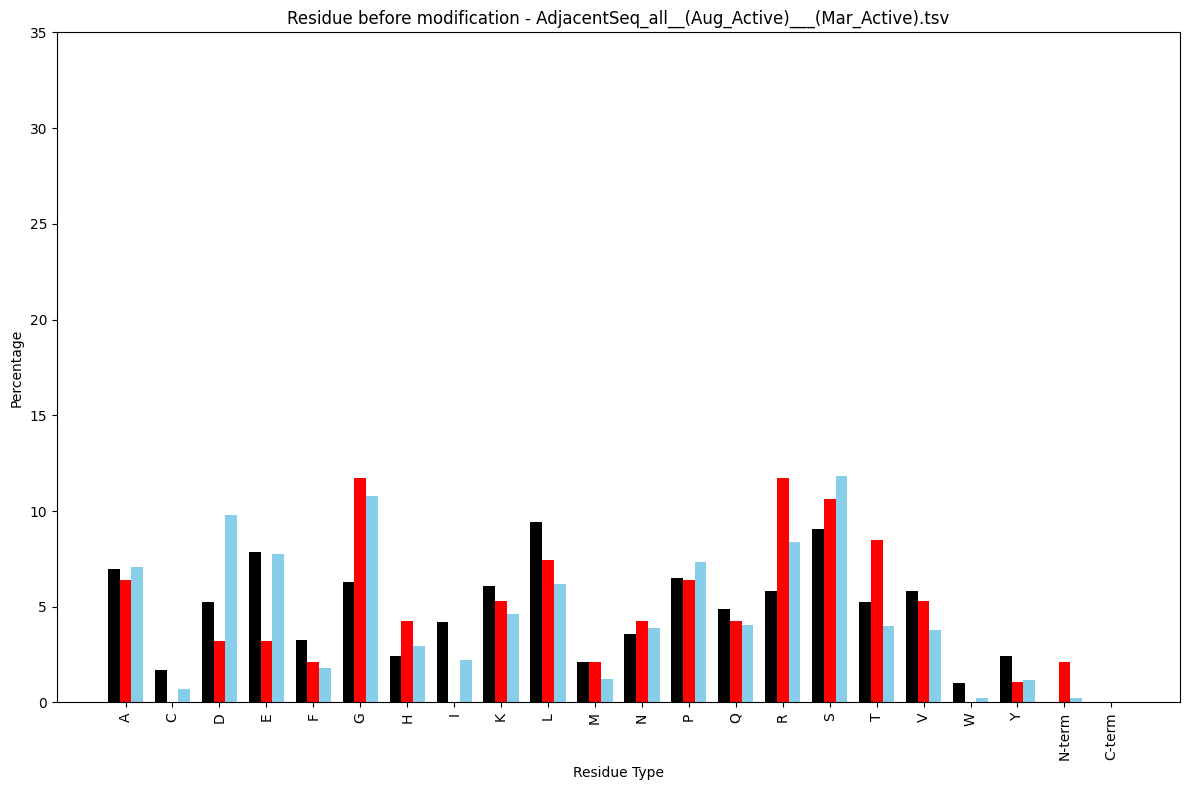

Number of Unique Accession Numbers for Significant Data in AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv: 15
Number of Unique Accession Numbers for Not Significant Data in AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv: 3212
Total number of modifications in AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv: 17793
Significant N-terminal (Met-loss) modifications: 2
Non-significant N-terminal (Met-loss) modifications: 41
Processing file: /content/output/modlist_files/AdjacentSeq_all__(Torpor)___(Aug_Active).tsv


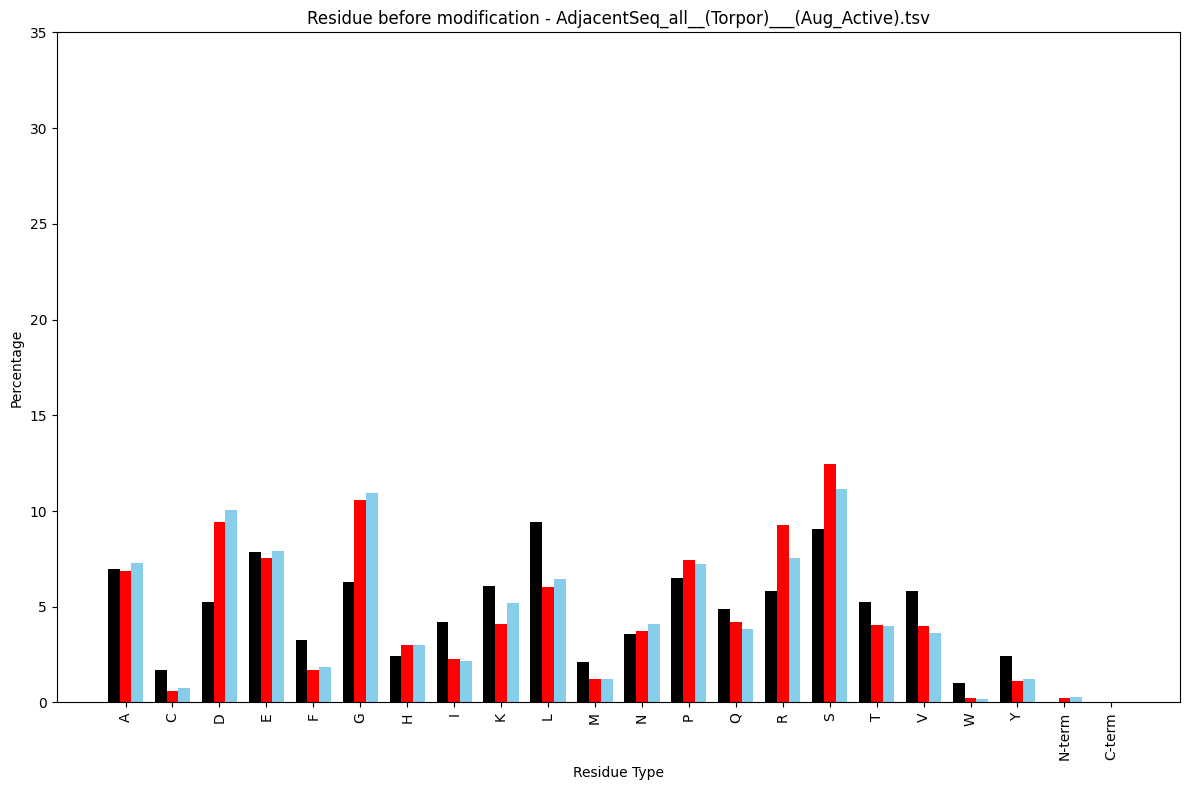

Number of Unique Accession Numbers for Significant Data in AdjacentSeq_all__(Torpor)___(Aug_Active).tsv: 1337
Number of Unique Accession Numbers for Not Significant Data in AdjacentSeq_all__(Torpor)___(Aug_Active).tsv: 1890
Total number of modifications in AdjacentSeq_all__(Torpor)___(Aug_Active).tsv: 17793
Significant N-terminal (Met-loss) modifications: 19
Non-significant N-terminal (Met-loss) modifications: 24
Processing file: /content/output/modlist_files/AdjacentSeq_all__(Mar_Active)___(Torpor).tsv


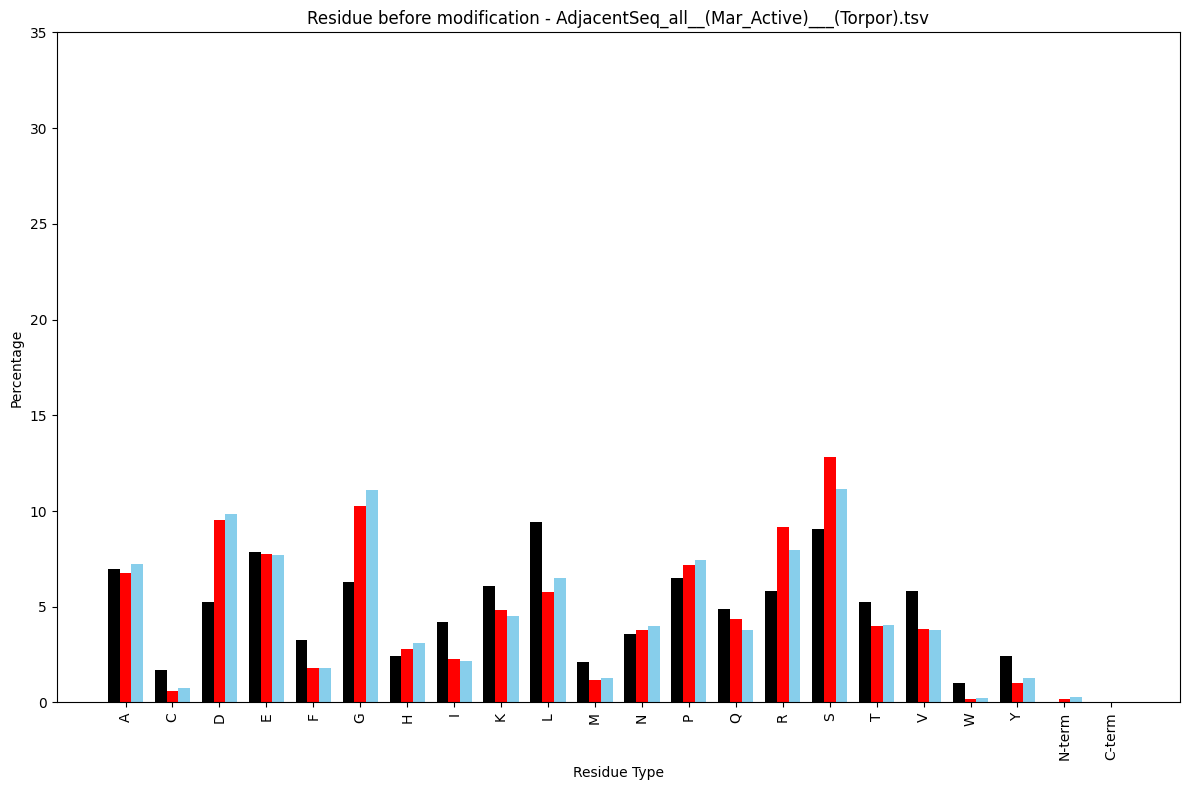

Number of Unique Accession Numbers for Significant Data in AdjacentSeq_all__(Mar_Active)___(Torpor).tsv: 1062
Number of Unique Accession Numbers for Not Significant Data in AdjacentSeq_all__(Mar_Active)___(Torpor).tsv: 2165
Total number of modifications in AdjacentSeq_all__(Mar_Active)___(Torpor).tsv: 17793
Significant N-terminal (Met-loss) modifications: 13
Non-significant N-terminal (Met-loss) modifications: 30
Processing complete.


In [2]:
#@title Plot of amino acid type BEFORE modification

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def calculate_aa_percentages(fasta_dir):
    aa_counts = {'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'P': 0, 'Q': 0, 'R': 0, 'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 0}
    n_term_counts = {key: 0 for key in aa_counts}
    c_term_counts = {key: 0 for key in aa_counts}
    total_residues = 0

    for filename in os.listdir(fasta_dir):
        if filename.endswith('.fasta'):
            with open(os.path.join(fasta_dir, filename), 'r') as f:
                _ = f.readline()  # Skip header
                sequence = f.readline().strip()
                if sequence:
                    total_residues += len(sequence)
                    for aa in sequence:
                        if aa in aa_counts:
                            aa_counts[aa] += 1
                    if sequence[0] in n_term_counts:
                        n_term_counts[sequence[0]] += 1
                    if sequence[-1] in c_term_counts:
                        c_term_counts[sequence[-1]] += 1

    aa_percentages = {key: (count / total_residues) * 100 for key, count in aa_counts.items()}
    n_term_percentages = {key: (count / total_residues) * 100 for key, count in n_term_counts.items()}
    c_term_percentages = {key: (count / total_residues) * 100 for key, count in c_term_counts.items()}

    # Print statements for total residues, A residues, and percentage of A residues
    print(f"Total number of residues: {total_residues}")
    print(f"Number of A residues: {aa_counts['A']}")
    print(f"Percentage of A residues: {aa_percentages['A']}%")

    return aa_percentages, n_term_percentages, c_term_percentages

def plot_last_column(file_path, log_file, aa_percentages, n_term_percentages, c_term_percentages):
    significant_characters_count = {key: 0 for key in aa_percentages}
    non_significant_characters_count = {key: 0 for key in aa_percentages}

    # Include 'N-term' and 'C-term' in the dictionaries
    significant_characters_count['N-term'] = 0
    significant_characters_count['C-term'] = 0
    non_significant_characters_count['N-term'] = 0
    non_significant_characters_count['C-term'] = 0

    unique_accession_numbers_significant = set()
    unique_accession_numbers_non_significant = set()

    total_modifications = 0
    significant_modifications = 0
    non_significant_modifications = 0

    significant_met_loss_count = 0
    non_significant_met_loss_count = 0

    with open(file_path, 'r') as file:
        # Skip header
        header = next(file)
        write_log(log_file, f"Processing file: {file_path}")

        for line in file:
            line = line.strip()
            if line:
                columns = line.split('\t')
                if len(columns) != 6:  # Ensure the line has exactly 6 columns
                    write_log(log_file, f"Skipping malformed line: {line}")
                    continue

                accession_number = columns[0]
                p_value = float(columns[3])
                last_column = columns[4]  # Ensure the modifications are in the correct column
                sequence_column = columns[5]  # Ensure the sequence is in the correct column

                total_modifications += 1

                is_n_term = last_column.startswith('Met-loss')
                if is_n_term:
                    character = 'N-term'
                else:
                    if len(sequence_column) >= 7:
                        character = sequence_column[6]
                    else:
                        write_log(log_file, f"Skipping sequence due to insufficient length: {sequence_column}")
                        continue

                if p_value < 0.05:
                    significant_modifications += 1
                    unique_accession_numbers_significant.add(accession_number)
                    if character in significant_characters_count:
                        significant_characters_count[character] += 1
                    if is_n_term:
                        significant_met_loss_count += 1
                else:
                    non_significant_modifications += 1
                    unique_accession_numbers_non_significant.add(accession_number)
                    if character in non_significant_characters_count:
                        non_significant_characters_count[character] += 1
                    if is_n_term:
                        non_significant_met_loss_count += 1

    # Calculate percentages for significant and non-significant modifications
    significant_characters_percent = {key: (value / significant_modifications) * 100 if significant_modifications > 0 else 0 for key, value in significant_characters_count.items()}
    non_significant_characters_percent = {key: (value / non_significant_modifications) * 100 if non_significant_modifications > 0 else 0 for key, value in non_significant_characters_count.items()}

    # Plot data
    categories = list(significant_characters_percent.keys())
    bar_width = 0.25
    x = np.arange(len(categories))
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.bar(x - bar_width, [aa_percentages.get(cat, 0) for cat in categories], bar_width, color='black', label='All Data')
    ax1.bar(x, [significant_characters_percent.get(cat, 0) for cat in categories], bar_width, color='red', label='Significant (p < 0.05)')
    ax1.bar(x + bar_width, [non_significant_characters_percent.get(cat, 0) for cat in categories], bar_width, color='skyblue', label='Not Significant (p >= 0.05)')

    ax1.set_ylabel('Percentage')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.set_xlabel('Residue Type')
    ax1.set_title(f'Residue before modification - {os.path.basename(file_path)}')
    ax1.set_ylim(0, 35)

    plt.xticks(rotation=90)
    plt.tight_layout()

    # Save plot
    output_dir = 'output/plots/adjacent_aa'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_filename = os.path.basename(file_path).replace('.tsv', '')
    plt.savefig(os.path.join(output_dir, f'AA_beforemod_{output_filename}.eps'))      # Saves as eps format image

    plt.show()

    # Log number of unique accession numbers and modifications
    write_log(log_file, f"Number of Unique Accession Numbers for Significant Data in {os.path.basename(file_path)}: {len(unique_accession_numbers_significant)}")
    write_log(log_file, f"Number of Unique Accession Numbers for Not Significant Data in {os.path.basename(file_path)}: {len(unique_accession_numbers_non_significant)}")
    write_log(log_file, f"Total number of modifications in {os.path.basename(file_path)}: {total_modifications}")

    # Print statements for Met-loss modifications
    print(f"Significant N-terminal (Met-loss) modifications: {significant_met_loss_count}")
    print(f"Non-significant N-terminal (Met-loss) modifications: {non_significant_met_loss_count}")

# Directory containing the files
directory = '/content/output/modlist_files'
fasta_dir = '/content/output/libraries/all_protein_seq'
logs_directory = os.path.join('output/logs')
os.makedirs(logs_directory, exist_ok=True)
log_file = os.path.join(logs_directory, "AA_before_mod.log")

# Calculate amino acid percentages for all protein residues
aa_percentages, n_term_percentages, c_term_percentages = calculate_aa_percentages(fasta_dir)

# Process each file
for filename in os.listdir(directory):
    if filename.startswith('AdjacentSeq') and filename.endswith('.tsv'):
        file_path = os.path.join(directory, filename)
        plot_last_column(file_path, log_file, aa_percentages, n_term_percentages, c_term_percentages)

write_log(log_file, "Processing complete.")


Total number of residues: 2697361
Number of A residues: 187384
Percentage of A residues: 6.946938136941997%
Processing file: /content/output/modlist_files/AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv


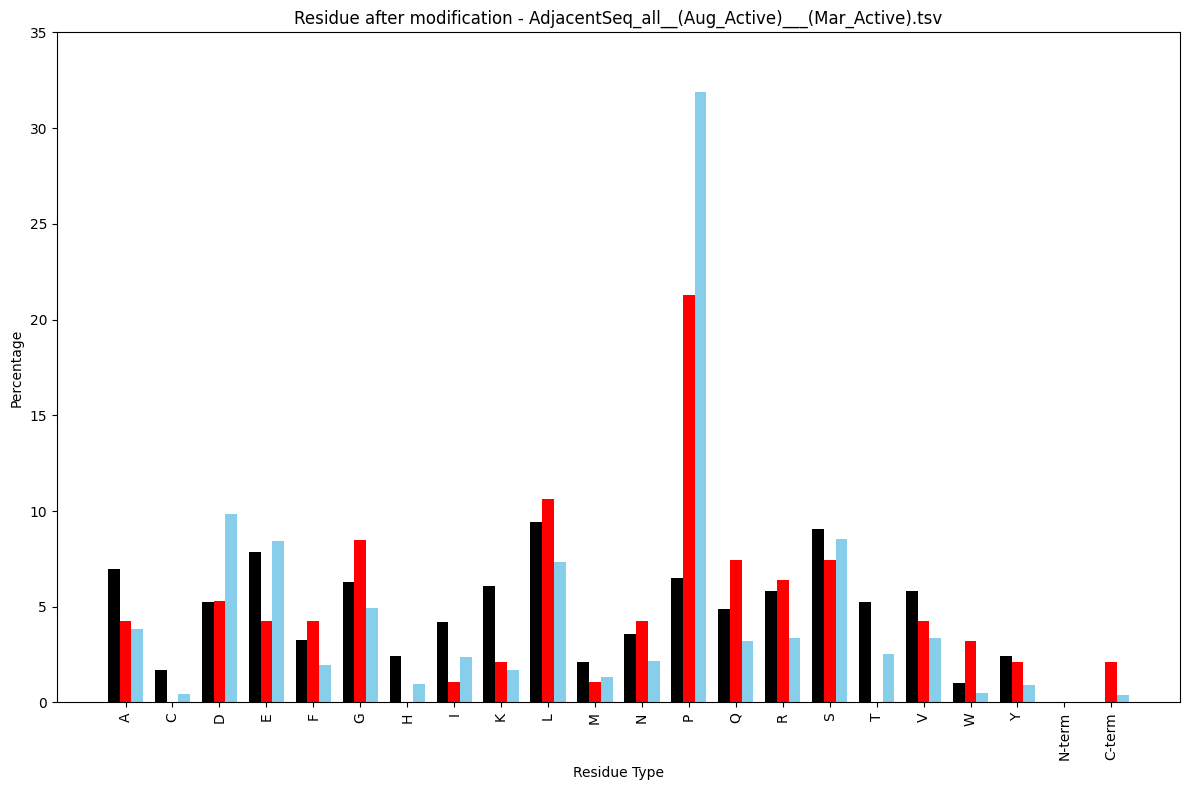

Number of Unique Accession Numbers for Significant Data in AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv: 15
Number of Unique Accession Numbers for Not Significant Data in AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv: 3212
Total number of modifications in AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv: 17793
Significant N-terminal (Met-loss) modifications: 2
Non-significant N-terminal (Met-loss) modifications: 41
Processing file: /content/output/modlist_files/AdjacentSeq_all__(Torpor)___(Aug_Active).tsv


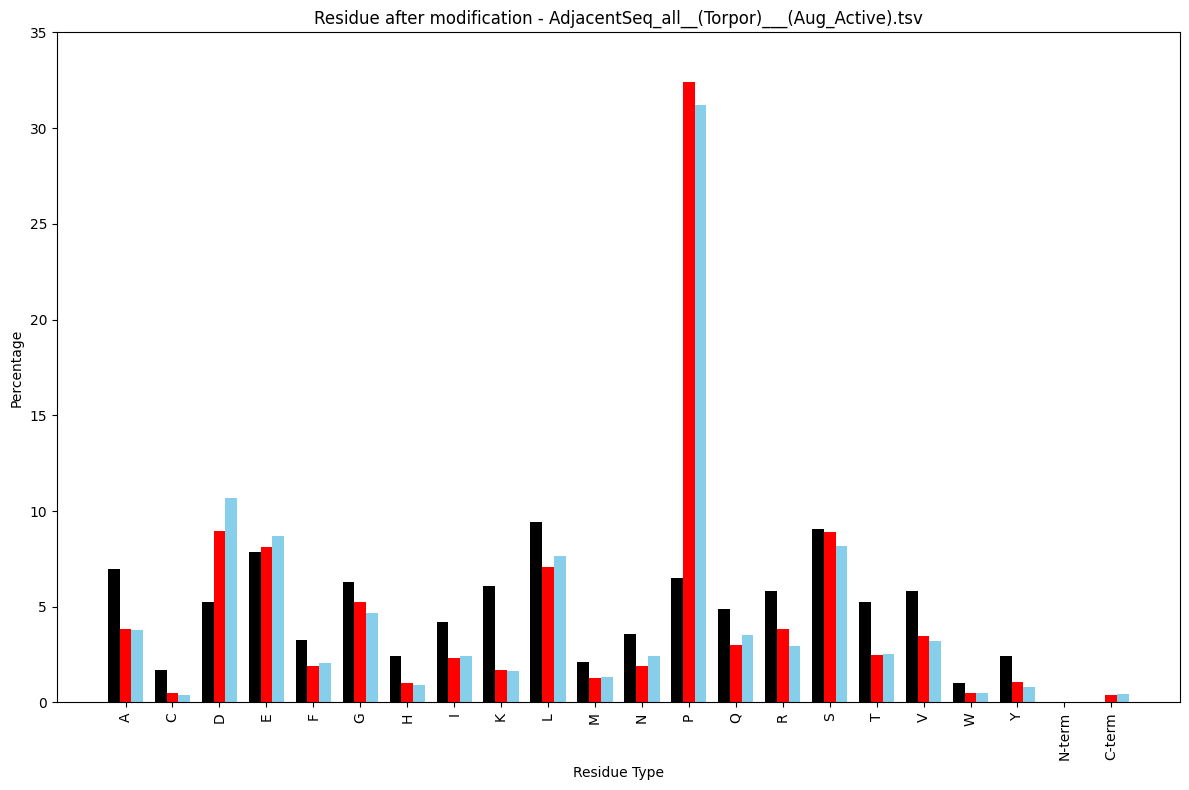

Number of Unique Accession Numbers for Significant Data in AdjacentSeq_all__(Torpor)___(Aug_Active).tsv: 1337
Number of Unique Accession Numbers for Not Significant Data in AdjacentSeq_all__(Torpor)___(Aug_Active).tsv: 1890
Total number of modifications in AdjacentSeq_all__(Torpor)___(Aug_Active).tsv: 17793
Significant N-terminal (Met-loss) modifications: 19
Non-significant N-terminal (Met-loss) modifications: 24
Processing file: /content/output/modlist_files/AdjacentSeq_all__(Mar_Active)___(Torpor).tsv


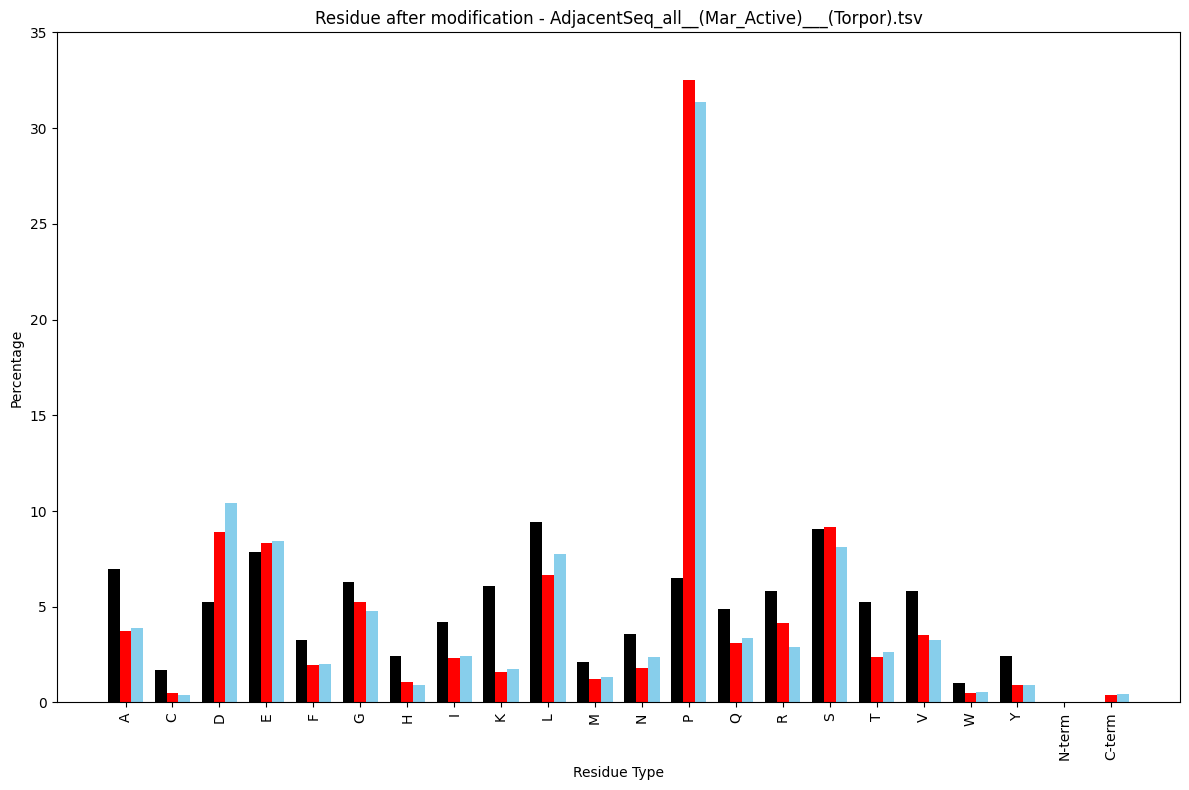

Number of Unique Accession Numbers for Significant Data in AdjacentSeq_all__(Mar_Active)___(Torpor).tsv: 1062
Number of Unique Accession Numbers for Not Significant Data in AdjacentSeq_all__(Mar_Active)___(Torpor).tsv: 2165
Total number of modifications in AdjacentSeq_all__(Mar_Active)___(Torpor).tsv: 17793
Significant N-terminal (Met-loss) modifications: 13
Non-significant N-terminal (Met-loss) modifications: 30
Processing complete.


In [3]:
#@title Plot of amino acid type AFTER modification (significant vs not significant modifications)

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def calculate_aa_percentages(fasta_dir):
    aa_counts = {'A': 0, 'C': 0, 'D': 0, 'E': 0, 'F': 0, 'G': 0, 'H': 0, 'I': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'P': 0, 'Q': 0, 'R': 0, 'S': 0, 'T': 0, 'V': 0, 'W': 0, 'Y': 0}
    n_term_counts = {key: 0 for key in aa_counts}
    c_term_counts = {key: 0 for key in aa_counts}
    total_residues = 0

    for filename in os.listdir(fasta_dir):
        if filename.endswith('.fasta'):
            with open(os.path.join(fasta_dir, filename), 'r') as f:
                _ = f.readline()  # Skip header
                sequence = f.readline().strip()
                if sequence:
                    total_residues += len(sequence)
                    for aa in sequence:
                        if aa in aa_counts:
                            aa_counts[aa] += 1
                    if sequence[0] in n_term_counts:
                        n_term_counts[sequence[0]] += 1
                    if sequence[-1] in c_term_counts:
                        c_term_counts[sequence[-1]] += 1

    aa_percentages = {key: (count / total_residues) * 100 for key, count in aa_counts.items()}
    n_term_percentages = {key: (count / total_residues) * 100 for key, count in n_term_counts.items()}
    c_term_percentages = {key: (count / total_residues) * 100 for key, count in c_term_counts.items()}

    # Print statements for total residues, A residues, and percentage of A residues
    print(f"Total number of residues: {total_residues}")
    print(f"Number of A residues: {aa_counts['A']}")
    print(f"Percentage of A residues: {aa_percentages['A']}%")

    return aa_percentages, n_term_percentages, c_term_percentages

def plot_last_column(file_path, log_file, aa_percentages, n_term_percentages, c_term_percentages):
    significant_characters_count = {key: 0 for key in aa_percentages}
    non_significant_characters_count = {key: 0 for key in aa_percentages}

    # Include 'N-term' and 'C-term' in the dictionaries
    significant_characters_count['N-term'] = 0
    significant_characters_count['C-term'] = 0
    non_significant_characters_count['N-term'] = 0
    non_significant_characters_count['C-term'] = 0

    unique_accession_numbers_significant = set()
    unique_accession_numbers_non_significant = set()

    total_modifications = 0
    significant_modifications = 0
    non_significant_modifications = 0

    significant_met_loss_count = 0
    non_significant_met_loss_count = 0

    with open(file_path, 'r') as file:
        # Skip header
        header = next(file)
        write_log(log_file, f"Processing file: {file_path}")

        for line in file:
            line = line.strip()
            if line:
                columns = line.split('\t')
                if len(columns) != 6:  # Ensure the line has exactly 6 columns
                    write_log(log_file, f"Skipping malformed line: {line}")
                    continue

                accession_number = columns[0]
                p_value = float(columns[3])
                last_column = columns[4]  # Ensure the modifications are in the correct column
                sequence_column = columns[5]  # Ensure the sequence is in the correct column

                total_modifications += 1

                is_n_term = last_column.startswith('Met-loss')
                is_met_loss_acetyl = 'Met-loss+Acetyl' in last_column
                character = 'C-term' if len(sequence_column) < 9 else sequence_column[8]

                if character not in significant_characters_count:
                    significant_characters_count[character] = 0
                if character not in non_significant_characters_count:
                    non_significant_characters_count[character] = 0

                if p_value < 0.05:
                    significant_modifications += 1
                    unique_accession_numbers_significant.add(accession_number)
                    significant_characters_count[character] += 1
                    if is_n_term:
                        significant_met_loss_count += 1
                else:
                    non_significant_modifications += 1
                    unique_accession_numbers_non_significant.add(accession_number)
                    non_significant_characters_count[character] += 1
                    if is_n_term:
                        non_significant_met_loss_count += 1

    # Calculate percentages for significant and non-significant modifications
    significant_characters_percent = {key: (value / significant_modifications) * 100 if significant_modifications > 0 else 0 for key, value in significant_characters_count.items()}
    non_significant_characters_percent = {key: (value / non_significant_modifications) * 100 if non_significant_modifications > 0 else 0 for key, value in non_significant_characters_count.items()}

    # Plot data
    categories = list(significant_characters_percent.keys())
    bar_width = 0.25
    x = np.arange(len(categories))
    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.bar(x - bar_width, [aa_percentages.get(cat, 0) for cat in categories], bar_width, color='black', label='All Data')
    ax1.bar(x, [significant_characters_percent.get(cat, 0) for cat in categories], bar_width, color='red', label='Significant (p < 0.05)')
    ax1.bar(x + bar_width, [non_significant_characters_percent.get(cat, 0) for cat in categories], bar_width, color='skyblue', label='Not Significant (p >= 0.05)')

    ax1.set_ylabel('Percentage')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.set_xlabel('Residue Type')
    ax1.set_title(f'Residue after modification - {os.path.basename(file_path)}')
    ax1.set_ylim(0, 35)

    plt.xticks(rotation=90)
    plt.tight_layout()

    # Save plot
    output_dir = 'output/plots/adjacent_aa'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_filename = os.path.basename(file_path).replace('.tsv', '')
    plt.savefig(os.path.join(output_dir, f'AA_aftermod_{output_filename}.eps'))      # Saves as eps format image

    plt.show()

    # Log number of unique accession numbers and modifications
    write_log(log_file, f"Number of Unique Accession Numbers for Significant Data in {os.path.basename(file_path)}: {len(unique_accession_numbers_significant)}")
    write_log(log_file, f"Number of Unique Accession Numbers for Not Significant Data in {os.path.basename(file_path)}: {len(unique_accession_numbers_non_significant)}")
    write_log(log_file, f"Total number of modifications in {os.path.basename(file_path)}: {total_modifications}")

    # Print statements for Met-loss modifications
    print(f"Significant N-terminal (Met-loss) modifications: {significant_met_loss_count}")
    print(f"Non-significant N-terminal (Met-loss) modifications: {non_significant_met_loss_count}")

# Directory containing the files
directory = '/content/output/modlist_files'
fasta_dir = '/content/output/libraries/all_protein_seq'
logs_directory = os.path.join('output/logs')
os.makedirs(logs_directory, exist_ok=True)
log_file = os.path.join(logs_directory, "AA_after_mod.log")

# Calculate amino acid percentages for all protein residues
aa_percentages, n_term_percentages, c_term_percentages = calculate_aa_percentages(fasta_dir)

# Process each file
for filename in os.listdir(directory):
    if filename.startswith('AdjacentSeq') and filename.endswith('.tsv'):
        file_path = os.path.join(directory, filename)
        plot_last_column(file_path, log_file, aa_percentages, n_term_percentages, c_term_percentages)

write_log(log_file, "Processing complete.")


In [4]:
#@title Plot of secondary structure element for modifications (all, sig, and not sig)
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def unify_indices(*dataframes):
    unified_index = dataframes[0].index
    for df in dataframes[1:]:
        unified_index = unified_index.union(df.index)
    return [df.reindex(unified_index, fill_value=0) for df in dataframes]

def calculate_all_residues_structure(directory):
    """Calculate secondary structure counts for all residues in all proteins in the dataset."""
    all_residue_counts = pd.Series(dtype=int)
    for filename in os.listdir(directory):
        if filename.endswith("_ss.tsv"):
            df = pd.read_csv(os.path.join(directory, filename), delimiter='\t')
            df.columns = df.columns.str.strip()
            if 'Secondary Structure' not in df.columns:
                continue
            structure_counts = df['Secondary Structure'].value_counts()
            all_residue_counts = all_residue_counts.add(structure_counts, fill_value=0)
    return all_residue_counts

def plot_secondary_structures(all_mods_directory, all_residues_directory, output_figures_directory, text_files_directory, log_file):
    os.makedirs(output_figures_directory, exist_ok=True)
    os.makedirs(text_files_directory, exist_ok=True)

    # Dictionary for full names of DSSP codes
    structure_names = {
        'H': 'Alpha-helix',
        'B': 'Isolated beta-bridge',
        'E': 'Beta-strand',
        'G': '3-10 helix',
        'I': 'Pi helix',
        'T': 'Turn',
        'S': 'Bend',
        '-': 'None'
    }

    # Order to plot secondary structures
    plot_order = ['None', 'Bend', 'Turn', 'Alpha-helix', '3-10 helix', 'Pi helix', 'Beta-strand', 'Isolated beta-bridge']

    # Calculate all residues structure counts
    all_residue_counts = calculate_all_residues_structure(all_residues_directory)
    all_residue_counts.index = all_residue_counts.index.map(structure_names)

    for filename in os.listdir(all_mods_directory):
        if "failed" not in filename and filename.startswith("all_mods_ss_") and filename.endswith(".tsv"):
            write_log(log_file, f"Processing file: {filename}")
            all_mods_file_path = os.path.join(all_mods_directory, filename)

            all_mods_df = pd.read_csv(all_mods_file_path, delimiter='\t')
            all_mods_df.columns = all_mods_df.columns.str.strip()

            if 'Secondary Structure' not in all_mods_df.columns or 'Adj. P-Value' not in all_mods_df.columns:
                write_log(log_file, "Required column missing in the dataframe.")
                continue

            all_mods_df['Secondary Structure'] = all_mods_df['Secondary Structure'].str.strip().map(structure_names)

            sig_df = all_mods_df[all_mods_df['Adj. P-Value'] < 0.05]
            notsig_df = all_mods_df[all_mods_df['Adj. P-Value'] >= 0.05]

            sig_structure_counts = sig_df['Secondary Structure'].value_counts()
            all_mods_structure_counts = all_mods_df['Secondary Structure'].value_counts()
            notsig_mods_structure_counts = notsig_df['Secondary Structure'].value_counts()

            # Calculate percentages for plotting
            sig_total = sig_structure_counts.sum()
            all_total = all_mods_structure_counts.sum()
            notsig_total = notsig_mods_structure_counts.sum()
            all_residues_total = all_residue_counts.sum()

            sig_structure_percentages = (sig_structure_counts / sig_total * 100)
            all_mods_structure_percentages = (all_mods_structure_counts / all_total * 100)
            notsig_mods_structure_percentages = (notsig_mods_structure_counts / notsig_total * 100)
            all_residues_percentages = (all_residue_counts / all_residues_total * 100)

            sig_structure_percentages, all_mods_structure_percentages, notsig_mods_structure_percentages, all_residues_percentages = unify_indices(
                sig_structure_percentages, all_mods_structure_percentages, notsig_mods_structure_percentages, all_residues_percentages)

            # Reorder percentages according to plot_order
            sig_structure_percentages = sig_structure_percentages.reindex(plot_order, fill_value=0)
            all_mods_structure_percentages = all_mods_structure_percentages.reindex(plot_order, fill_value=0)
            notsig_mods_structure_percentages = notsig_mods_structure_percentages.reindex(plot_order, fill_value=0)
            all_residues_percentages = all_residues_percentages.reindex(plot_order, fill_value=0)

            plt.rcParams['font.family'] = 'Liberation Sans'  # Set the font to Liberation Sans

            fig, ax = plt.subplots(figsize=(8, 8))  # Make the plot square
            index = np.arange(len(sig_structure_percentages))
            bar_width = 0.2

            ax.bar(index, all_residues_percentages, bar_width, label='All Residues', color='black')
            ax.bar(index + bar_width, sig_structure_percentages, bar_width, label='Significant', color='red')

            ax.set_xlabel('Secondary Structure')
            ax.set_ylabel('Percentage')
            ax.set_ylim(0, 100)
            ax.yaxis.set_major_formatter(PercentFormatter())
            ax.set_title(f'Percentage of Each Secondary Structure Type in {filename}')
            ax.set_xticks(index)
            ax.set_xticklabels(plot_order)

            # Move legend to top right corner and remove the frame
            legend = ax.legend(loc='upper right', frameon=False)

            # Display the number of unique accession numbers
            sig_unique_accessions = len(sig_df['Accession Number'].unique())
            all_unique_accessions = len(all_mods_df['Accession Number'].unique())
            notsig_unique_accessions = len(notsig_df['Accession Number'].unique())
            ax.text(0.885, 0.70, f'Significant: {sig_unique_accessions}', transform=ax.transAxes, verticalalignment='top')
            ax.text(0.885, 0.65, f'All Mods: {all_unique_accessions}', transform=ax.transAxes, verticalalignment='top')
            ax.text(0.885, 0.60, f'Not Significant: {notsig_unique_accessions}', transform=ax.transAxes, verticalalignment='top')

            plt.xticks(rotation=45)
            plt.tight_layout()

            plot_filename = os.path.join(output_figures_directory, f'SStype_percent_{filename[:-4]}.eps')
            plt.savefig(plot_filename)
            plt.close()
            write_log(log_file, f"Plot saved to {plot_filename}")

            # Save counts to text file
            text_filename = os.path.join(text_files_directory, f'SStype_{filename[11:-4].replace("__", "-")}.txt')
            with open(text_filename, 'w') as text_file:
                text_file.write(f"File: {filename}\n")
                text_file.write(f"Total modifications (Significant): {sig_total}\n")
                text_file.write(f"Total modifications (All Mods): {all_total}\n")
                text_file.write(f"Total modifications (Not Significant): {notsig_total}\n")
                text_file.write(f"Total residues (All Residues): {all_residues_total}\n")
                text_file.write("\nSecondary Structure Counts (Significant):\n")
                for structure, count in sig_structure_counts.reindex(plot_order, fill_value=0).items():
                    text_file.write(f"{structure}: {count}\n")
                text_file.write("\nSecondary Structure Counts (All Mods):\n")
                for structure, count in all_mods_structure_counts.reindex(plot_order, fill_value=0).items():
                    text_file.write(f"{structure}: {count}\n")
                text_file.write("\nSecondary Structure Counts (Not Significant):\n")
                for structure, count in notsig_mods_structure_counts.reindex(plot_order, fill_value=0).items():
                    text_file.write(f"{structure}: {count}\n")
                text_file.write("\nSecondary Structure Counts (All Residues):\n")
                for structure, count in all_residue_counts.reindex(plot_order, fill_value=0).items():
                    text_file.write(f"{structure}: {count}\n")

            write_log(log_file, f"Counts saved to {text_filename}")

            # Print statements for the unique accession numbers and modifications
            print(f"File: {filename}")
            print(f"Number of unique accession numbers: {len(sig_df['Accession Number'].unique())}")
            print(f"Number of significant modifications: {sig_total}")
            print(f"Number of all modifications: {all_total}")
            print(f"Number of not significant modifications: {notsig_total}")
            print(f"Number of all residues: {all_residues_total}")

def main():
    all_mods_directory = "/content/output/modlist_files"  # Directory containing all mods files
    all_residues_directory = "/content/output/libraries/all_protein_ss"  # Directory containing all residues files
    output_figures_directory = "/content/output/plots/SStype"  # Directory to save plots
    text_files_directory = "/content/output/text_files"  # Directory to save text files
    logs_directory = "/content/output/logs"
    os.makedirs(logs_directory, exist_ok=True)
    log_file = os.path.join(logs_directory, "ss-type_process.log")

    plot_secondary_structures(all_mods_directory, all_residues_directory, output_figures_directory, text_files_directory, log_file)

if __name__ == "__main__":
    main()


Processing file: all_mods_ss_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
Plot saved to /content/output/plots/SStype/SStype_percent_all_mods_ss_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).eps
Counts saved to /content/output/text_files/SStype__Abundance_Ratio_(log2)-(Aug_Active)-_(Mar_Active).txt
File: all_mods_ss_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
Number of unique accession numbers: 15
Number of significant modifications: 94
Number of all modifications: 16026
Number of not significant modifications: 15932
Number of all residues: 2349857.0
Processing file: all_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Plot saved to /content/output/plots/SStype/SStype_percent_all_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).eps
Counts saved to /content/output/text_files/SStype__Abundance_Ratio_(log2)-(Torpor)-_(Aug_Active).txt
File: all_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Number of unique accession numbers: 1286


In [57]:
#@title Identifies whether residues are in a domain vs "no domain" for all protein residues and modified residues for significant datasets

import os
import re
import pandas as pd
from Bio import SeqIO
import numpy as np

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def count_domain_presence(df):
    """Count the number of modification sites in 'Domain' and 'No Domain' categories."""
    domain_count = df[df['Domain Type'] != 'No Domain'].shape[0]
    no_domain_count = df[df['Domain Type'] == 'No Domain'].shape[0]
    return domain_count, no_domain_count

def calculate_percentage(domain_count, total_count):
    """Calculate the percentage of domain presence."""
    if total_count == 0:
        return 0
    return (domain_count / total_count) * 100

def extract_filename_info(filename):
    """Extract the relevant part of the filename (e.g., (Torpor) vs (Aug Active))"""
    match = re.search(r'domain_sig_modlist_all_modlist_Abundance_Ratio_\(log2\)__\(([^)]+)\)___\(([^)]+)\).tsv', filename)
    if match:
        return f"{match.group(1)} vs {match.group(2)}"
    else:
        return filename

def read_fasta_sequences(fasta_directory):
    """Read all FASTA files in the directory and return a dictionary of sequences."""
    sequences = {}
    for fasta_file in os.listdir(fasta_directory):
        if fasta_file.endswith(".fasta"):
            accession_number = os.path.splitext(fasta_file)[0]
            fasta_path = os.path.join(fasta_directory, fasta_file)
            for record in SeqIO.parse(fasta_path, "fasta"):
                sequences[accession_number] = str(record.seq)
    return sequences

def process_files(all_directory, fasta_directory, domain_library_path, log_file):
    results = []
    combined_sig_df = pd.DataFrame()  # DataFrame to hold all significant data combined

    # Check if the directory exists
    if not os.path.exists(all_directory):
        write_log(log_file, f"Directory does not exist: {all_directory}")
        return

    # Read domain library
    domain_library = pd.read_csv(domain_library_path, delimiter='\t')

    # Read FASTA sequences
    sequences = read_fasta_sequences(fasta_directory)

    all_residues_domain_count = 0
    all_residues_no_domain_count = 0
    all_residues_total_count = 0

    protein_lengths = []

    for accession, sequence in sequences.items():
        protein_length = len(sequence)
        all_residues_total_count += protein_length
        protein_lengths.append(protein_length)

        domains = domain_library[domain_library['Accession'] == accession]
        domain_ranges = [(row['Domain Start'], row['Domain End']) for index, row in domains.iterrows()]

        for i in range(1, protein_length + 1):
            in_domain = False
            for start, end in domain_ranges:
                if start <= i <= end:
                    in_domain = True
                    break
            if in_domain:
                all_residues_domain_count += 1
            else:
                all_residues_no_domain_count += 1

    all_residues_domain_percentage = calculate_percentage(all_residues_domain_count, all_residues_total_count)
    all_residues_no_domain_percentage = calculate_percentage(all_residues_no_domain_count, all_residues_total_count)

    # Add all residues summary row
    results.append({
        'Dataset': 'All residues',
        'Domain': f"{all_residues_domain_percentage:.0f}%",
        'No Domain': f"{all_residues_no_domain_percentage:.0f}%",
        '# residues': all_residues_total_count,
        '# proteins': len(sequences)
    })

    for filename in os.listdir(all_directory):
        if filename.startswith("domain_sig_modlist") and filename.endswith(".tsv") and "notsig" not in filename:
            all_file_path = os.path.join(all_directory, filename)

            write_log(log_file, f"Processing file: {filename}")

            try:
                all_df = pd.read_csv(all_file_path, delimiter='\t').drop_duplicates()

                # Determine significant data
                sig_df = all_df[all_df['Adj. P-Value'] < 0.05].copy()

                # Ensure 'Domain Type' column is present and filled with 'No Domain' where missing
                if 'Domain Type' not in all_df.columns:
                    all_df['Domain Type'] = 'No Domain'
                else:
                    all_df['Domain Type'] = all_df['Domain Type'].fillna('No Domain')

                if 'Domain Type' not in sig_df.columns:
                    sig_df['Domain Type'] = 'No Domain'
                else:
                    sig_df['Domain Type'] = sig_df['Domain Type'].fillna('No Domain')

                # Combine significant data for the final row
                combined_sig_df = pd.concat([combined_sig_df, sig_df]).drop_duplicates()

                # Count domain presence for significant data
                sig_domain_count, sig_no_domain_count = count_domain_presence(sig_df)
                total_sig_count = sig_df[sig_df['Accession Number'].isin(combined_sig_df['Accession Number'])].shape[0]
                sig_domain_percentage = calculate_percentage(sig_domain_count, total_sig_count)
                sig_no_domain_percentage = calculate_percentage(sig_no_domain_count, total_sig_count)
                sig_unique_proteins = sig_df['Accession Number'].nunique()

                # Extract relevant filename info
                filename_info = extract_filename_info(filename)

                # Add the results to the list for significant data
                results.append({
                    'Dataset': filename_info,
                    'Domain': f"{sig_domain_percentage:.0f}%",
                    'No Domain': f"{sig_no_domain_percentage:.0f}%",
                    '# residues': total_sig_count,
                    '# proteins': sig_unique_proteins
                })

                write_log(log_file, f"Processed {filename}: Sig Domain: {sig_domain_count}, Sig No Domain: {sig_no_domain_count}")

            except Exception as e:
                write_log(log_file, f"Error processing {filename}: {e}")

    # Combine significant data across all files
    combined_sig_df = combined_sig_df.drop_duplicates()
    sig_domain_count, sig_no_domain_count = count_domain_presence(combined_sig_df)
    total_sig_count = combined_sig_df[combined_sig_df['Accession Number'].isin(sequences.keys())].shape[0]
    sig_domain_percentage = calculate_percentage(sig_domain_count, total_sig_count)
    sig_no_domain_percentage = calculate_percentage(sig_no_domain_count, total_sig_count)
    sig_unique_proteins = combined_sig_df['Accession Number'].nunique()

    # Add the combined significant data row
    results.append({
        'Dataset': 'All significant',
        'Domain': f"{sig_domain_percentage:.0f}%",
        'No Domain': f"{sig_no_domain_percentage:.0f}%",
        '# residues': total_sig_count,
        '# proteins': sig_unique_proteins
    })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Print the table
    print(results_df)

    # Print protein length statistics
    shortest_protein = min(protein_lengths)
    longest_protein = max(protein_lengths)
    average_protein = np.mean(protein_lengths)
    stddev_protein = np.std(protein_lengths)

    print(f"Shortest protein length: {shortest_protein}")
    print(f"Longest protein length: {longest_protein}")
    print(f"Average protein length: {average_protein:.1f}")
    print(f"Standard deviation of protein lengths: {stddev_protein:.1f}")

    # Ensure the output directory exists
    output_text_directory = "/content/output/text_files"
    os.makedirs(output_text_directory, exist_ok=True)

    # Save the table to a CSV file
    output_file_path = os.path.join(output_text_directory, "domain_presence_summary.csv")
    results_df.to_csv(output_file_path, index=False)
    write_log(log_file, f"Results saved to {output_file_path}")

if __name__ == "__main__":
    all_directory = "/content/output/modlist_files"  # Directory containing all files
    fasta_directory = "/content/output/libraries/all_protein_seq"
    domain_library_path = "/content/output/libraries/domainlibrary.tsv"
    logs_directory = "/content/output/logs"
    os.makedirs(logs_directory, exist_ok=True)
    log_file = os.path.join(logs_directory, "domain_presence_process.log")
    process_files(all_directory, fasta_directory, domain_library_path, log_file)


Processing file: domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
Processed domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv: Sig Domain: 525, Sig No Domain: 6418
Processing file: domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
Processed domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv: Sig Domain: 19, Sig No Domain: 75
Processing file: domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Processed domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv: Sig Domain: 677, Sig No Domain: 8296
                                             Dataset Domain No Domain  \
0                                       All residues    26%       74%   
1  domain_sig_modlist_sig_modlist_Abundance_Ratio...     8%       92%   
2  domain_sig_modlist_sig_modlist_Abundance_Ratio...    20%       80%   
3  domain_

In [51]:
def combine_domain_sig_files(all_directory, output_combined_file):
    """Combine all domain_sig files into one file with all phosphosite residues."""
    combined_df = pd.DataFrame()

    # List all files in the directory for debugging
    print(f"Files in directory: {os.listdir(all_directory)}")

    for filename in os.listdir(all_directory):
        if filename.startswith("domain_sig_modlist") and filename.endswith(".tsv") and "notsig" not in filename:
            file_path = os.path.join(all_directory, filename)
            print(f"Processing file: {filename}")

            try:
                df = pd.read_csv(file_path, delimiter='\t')
                print(f"Number of rows in {filename}: {df.shape[0]}")
                combined_df = pd.concat([combined_df, df], ignore_index=True)
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # Check the total number of rows after combining
    print(f"Total rows in combined DataFrame before saving: {combined_df.shape[0]}")

    # Save the combined DataFrame to a file
    combined_df.to_csv(output_combined_file, index=False)

    # Confirm the number of rows in the saved file
    saved_df = pd.read_csv(output_combined_file)
    print(f"Total rows in combined file: {saved_df.shape[0]}")

    return combined_df


In [6]:
#@title Identify Kinases and map PTMs to Kinase domains and predict T-loop
import os
import shutil
import pandas as pd
import re

# Define directories
sig_mods_dir = '/content/output/modlist_files'
domain_library_path = '/content/output/libraries/domainlibrary.tsv'
disorder_files_dir = '/content//output/libraries/IUPred2A_disorder'
output_text_dir = '/content/output/text_files/Kinases'
output_plots_dir = '/content/output/plots/Kinases'
logs_directory = '/content/output/logs'
fasta_seq_dir = '/content//output/libraries/all_protein_seq'
log_file = os.path.join(logs_directory, "kinasedomainPTM_process.log")

# Ensure output directories exist
os.makedirs(output_text_dir, exist_ok=True)
os.makedirs(output_plots_dir, exist_ok=True)
os.makedirs(logs_directory, exist_ok=True)

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

def extract_iupred_score(disorder_files_dir, accession, residue_number):
    """Extracts the IUPred score for a given residue number from the corresponding disorder file."""
    disorder_file_path = os.path.join(disorder_files_dir, f'{accession}_iupred2a.txt')
    if os.path.exists(disorder_file_path):
        with open(disorder_file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                parts = line.split()
                if len(parts) == 3:
                    try:
                        residue = int(parts[0])
                        disorder_score = float(parts[2])
                        if residue == residue_number:
                            return disorder_score
                    except ValueError:
                        continue
    return 'N/A'

def extract_t_loop_sequence(fasta_seq_dir, accession):
    """Extracts the T-loop sequence from the fasta sequence file."""
    fasta_file_path = os.path.join(fasta_seq_dir, f'{accession}.fasta')
    if not os.path.exists(fasta_file_path):
        write_log(log_file, f"FASTA file not found: {fasta_file_path}")
        return None, None, None

    write_log(log_file, f"Searching FASTA file: {fasta_file_path}")

    with open(fasta_file_path, 'r') as file:
        sequence = ''.join([line.strip() for line in file if not line.startswith('>')])

    dfg_match = re.search(r'DFG', sequence)
    ape_match = re.search(r'PE', sequence)

    if dfg_match and ape_match and 0 < ape_match.start() - dfg_match.end() <= 50:
        t_loop_start = dfg_match.start()
        t_loop_end = ape_match.end()
        return t_loop_start + 1, t_loop_end + 1, sequence[t_loop_start:t_loop_end]

    return None, None, None

def extract_modifications_in_kinase_domains(sig_mods_dir, filtered_domains_df, disorder_files_dir, fasta_seq_dir, output_text_dir, output_plots_dir):
    t_loop_identified = 0
    t_loop_sequences = []

    for file in os.listdir(sig_mods_dir):
        if file.startswith('sig_mods_ss_') and file.endswith('.tsv'):
            sig_mods_path = os.path.join(sig_mods_dir, file)
            suffix = file[len('sig_mods_ss_'):-4]
            output_kd_file_path = os.path.join(output_text_dir, f'KinaseDomain_modifications_{suffix}.txt')
            output_not_in_kd_file_path = os.path.join(output_text_dir, f'Kinase_mod_notinKD_{suffix}.txt')

            with open(output_kd_file_path, 'w') as kd_outfile, open(output_not_in_kd_file_path, 'w') as notinkd_outfile:
                header = 'Accession Number\tGene ID\tAbundance Ratio\tModification\tDomain\tSecondary Structure\tSolvent Accessibility\tIUPred Score\tT-loop\tT-loop Sequence\n'
                kd_outfile.write(header)
                notinkd_outfile.write(header)

                sig_mods_df = pd.read_csv(sig_mods_path, delimiter='\t')
                total_modifications_kd = 0
                total_modifications_notinkd = 0

                for index, row in filtered_domains_df.iterrows():
                    accession = row['Accession']
                    domain_type = row['Domain Type']
                    domain_start = row['Domain Start']
                    domain_end = row['Domain End']

                    def extract_residue_number(modification):
                        if 'Met-loss' in modification:
                            return 1
                        try:
                            return int(''.join(filter(str.isdigit, str(modification))))
                        except ValueError:
                            return None

                    sig_mods_df['Residue Number'] = sig_mods_df['Modification'].apply(extract_residue_number)

                    domain_mods_df = sig_mods_df[(sig_mods_df['Accession Number'] == accession) &
                                                 (sig_mods_df['Residue Number'].notna()) &
                                                 (sig_mods_df['Residue Number'] >= domain_start) &
                                                 (sig_mods_df['Residue Number'] <= domain_end)]

                    not_in_domain_mods_df = sig_mods_df[(sig_mods_df['Accession Number'] == accession) &
                                                        (sig_mods_df['Residue Number'].notna()) &
                                                        ((sig_mods_df['Residue Number'] < domain_start) |
                                                         (sig_mods_df['Residue Number'] > domain_end))]

                    if not domain_mods_df.empty:
                        t_loop_start, t_loop_end, t_loop_seq = extract_t_loop_sequence(fasta_seq_dir, accession)

                    # Count modifications in Kinase domains
                    for mod_index, mod_row in domain_mods_df.iterrows():
                        gene_id = mod_row['Gene ID']
                        abundance_ratio = mod_row['Abundance Ratio (log2)']
                        modification = mod_row['Modification']
                        sec_structure = mod_row['Secondary Structure']
                        sol_access = mod_row['Solvent Accessibility']
                        residue_number = mod_row['Residue Number']
                        iupred_score = extract_iupred_score(disorder_files_dir, accession, residue_number)

                        t_loop_flag = 'No'
                        t_loop_seq_mod = 'N/A'

                        if t_loop_start is not None and t_loop_end is not None and t_loop_start <= residue_number <= t_loop_end:
                            t_loop_flag = 'Yes'
                            mod_position = residue_number - t_loop_start
                            t_loop_seq_mod = t_loop_seq[:mod_position] + t_loop_seq[mod_position].lower() + t_loop_seq[mod_position + 1:]
                            t_loop_identified += 1
                            t_loop_sequences.append((accession, t_loop_seq_mod))

                        kd_outfile.write(f'{accession}\t{gene_id}\t{abundance_ratio}\t{modification}\t{domain_type}\t{sec_structure}\t{sol_access}\t{iupred_score}\t{t_loop_flag}\t{t_loop_seq_mod}\n')
                        total_modifications_kd += 1

                    # Count modifications not in Kinase domains
                    for mod_index, mod_row in not_in_domain_mods_df.iterrows():
                        gene_id = mod_row['Gene ID']
                        abundance_ratio = mod_row['Abundance Ratio (log2)']
                        modification = mod_row['Modification']
                        sec_structure = mod_row['Secondary Structure']
                        sol_access = mod_row['Solvent Accessibility']
                        residue_number = mod_row['Residue Number']
                        iupred_score = extract_iupred_score(disorder_files_dir, accession, residue_number)

                        notinkd_outfile.write(f'{accession}\t{gene_id}\t{abundance_ratio}\t{modification}\tNone\t{sec_structure}\t{sol_access}\t{iupred_score}\tNo\tN/A\n')
                        total_modifications_notinkd += 1

                        # Copy relevant plots to output directory
                        for plot_type in ['disorder', 'sa']:
                            plot_file = f'{accession}_{plot_type}.png'
                            plot_path = os.path.join(f'/content/output/plots/{plot_type}_plots', plot_file)
                            if os.path.exists(plot_path):
                                shutil.copy(plot_path, output_plots_dir)

            write_log(log_file, f"Processed file: {file}")
            write_log(log_file, f"Total modifications in Kinase domains: {total_modifications_kd}")
            write_log(log_file, f"Total modifications to Kinase proteins, not in Kinase domains: {total_modifications_notinkd}")
            write_log(log_file, f"Results written to: {output_kd_file_path}")
            write_log(log_file, f"Results written to: {output_not_in_kd_file_path}")

    print(f"Total T-loop sequences identified: {t_loop_identified}")
    write_log(log_file, f"Total T-loop sequences identified: {t_loop_identified}")
    for accession, t_loop_seq_mod in t_loop_sequences:
        print(f"Accession {accession} T-loop sequence: {t_loop_seq_mod}")
        write_log(log_file, f"Accession {accession} T-loop sequence: {t_loop_seq_mod}")

# Load domain library and filter for Kinase domains
print("Reading domain library...")
domain_library_df = pd.read_csv(domain_library_path, delimiter='\t')
kinase_domains_pattern = re.compile(r'.*kinase.*', re.IGNORECASE)
filtered_domains_df = domain_library_df[domain_library_df['Domain Type'].str.contains(kinase_domains_pattern)]
print(f"Total Kinase domains found: {len(filtered_domains_df)}")

# Run the function to extract modifications
extract_modifications_in_kinase_domains(sig_mods_dir, filtered_domains_df, disorder_files_dir, fasta_seq_dir, output_text_dir, output_plots_dir)
print("Process complete.")


Reading domain library...
Total Kinase domains found: 270
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287CSI2.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287CRX6.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287CWW4.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287CX14.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287D132.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287D281.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287D2C7.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287D345.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287D3E9.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287D3P7.fasta
Searching FASTA file: /content//output/libraries/all_protein_seq/A0A287D3E2.fasta
Searching FASTA file: /content//output/l

In [7]:
#@title Histogram of IUPred score for significant modification vs all residues
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
from matplotlib.ticker import PercentFormatter
import numpy as np

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

# Define directories
directory_to_iupred_files = "/content/output/libraries/IUPred2A_disorder/"
modlist_dir = "/content/output/modlist_files/"
output_figures_path = "/content/output/plots/iupred_histograms"
logs_directory = "/content/output/logs"
log_file = os.path.join(logs_directory, "iupred_histogram_process.log")

# Ensure the output directory and logs directory exist
os.makedirs(output_figures_path, exist_ok=True)
os.makedirs(logs_directory, exist_ok=True)

def read_iupred_scores(filepath):
    """Reads IUPred scores from a given IUPred file."""
    iupred_scores = {}
    try:
        with open(filepath, 'r') as file:
            for line in file:
                if line.startswith('#') or not line.strip():
                    continue
                parts = line.strip().split()
                if len(parts) == 3:
                    try:
                        residue_number = int(parts[0])
                        iupred_score = float(parts[2])
                        iupred_scores[residue_number] = iupred_score
                    except ValueError:
                        continue  # Ignore conversion errors and continue
    except Exception as e:
        write_log(log_file, f"Error reading IUPred scores from {filepath}: {e}")
    return iupred_scores

def read_all_iupred_scores(directory):
    """Reads IUPred scores from files in the specified directory."""
    all_scores = []
    residue_count = 0
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            iupred_scores = read_iupred_scores(filepath)
            all_scores.extend(iupred_scores.values())
            residue_count += len(iupred_scores)
    return all_scores, residue_count

def read_modifications(filepath):
    """Reads modification information from the modlist file."""
    modifications = {}
    significant_data = {}
    not_significant_data = {}
    significant_accessions = set()
    try:
        data = pd.read_csv(filepath, delimiter='\t')  # Specify TSV delimiter
        data.columns = data.columns.str.strip()

        abundance_cols = [col for col in data.columns if 'Abundance Ratio (log2)' in col]
        p_value_cols = [col for col in data.columns if 'Adj. P-Value' in col]

        for p_col in p_value_cols:
            corresponding_abundance_col = p_col.replace('Adj. P-Value', 'Abundance Ratio (log2)').strip()
            if corresponding_abundance_col in abundance_cols:
                timepoint = p_col.replace('Adj. P-Value', '').strip()
                significant_data[timepoint] = []
                for index, row in data.iterrows():
                    try:
                        mod = str(row['Modifications'])
                        mod_residue = 1 if 'Met-loss' in mod else int(''.join(filter(str.isdigit, mod)))
                        p_value = float(row[p_col])
                        accession = row['Accession Number']
                        if pd.notna(mod_residue):
                            modifications.setdefault(accession, []).append(mod_residue)
                            if p_value < 0.05:
                                significant_data[timepoint].append((accession, mod_residue))
                                significant_accessions.add(accession)
                    except ValueError:
                        continue  # Ignore conversion errors and continue
            else:
                write_log(log_file, f"No matching abundance ratio column for {p_col} in file: {filepath}")

        write_log(log_file, f"Number of significant accessions extracted from {filepath}: {len(significant_accessions)}")
    except Exception as e:
        write_log(log_file, f"Error reading modifications from {filepath}: {e}")
    return modifications, significant_data, significant_accessions

def perform_welchs_anova(data1, data2, log_file):
    """Performs Welch's ANOVA test between two datasets."""
    if len(data1) < 2 or len(data2) < 2:
        write_log(log_file, "Not enough data to perform Welch's ANOVA test.")
        return float('nan')
    t_stat, p_value, _ = ttest_ind(data1, data2, usevar='unequal')
    write_log(log_file, f"Welch's ANOVA test result: T-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")
    return p_value

def process_file(filename):
    filepath = os.path.join(modlist_dir, filename)
    write_log(log_file, f"Processing file: {filepath}")
    if not os.path.exists(filepath):
        write_log(log_file, f"File does not exist: {filepath}")
        return

    modifications, significant_data, significant_accessions = read_modifications(filepath)

    if not significant_data:
        write_log(log_file, f"No significant data found in file: {filepath}")
        return

    # Read all IUPred scores for significant accessions
    all_scores, total_residues = read_all_iupred_scores(directory_to_iupred_files)

    if not all_scores:
        write_log(log_file, f"No matching IUPred scores found in {directory_to_iupred_files}")
        return

    significant_unstructured_scores = []

    # Extract IUPred scores for significant modifications
    for timepoint, mods in significant_data.items():
        for accession, residue in mods:
            iupred_filepath = os.path.join(directory_to_iupred_files, f"{accession}_iupred2a.txt")
            iupred_scores = read_iupred_scores(iupred_filepath)
            if residue in iupred_scores:
                significant_unstructured_scores.append(iupred_scores[residue])

    # Create plot with two different y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Histogram and KDE for all residues
    sns.histplot(all_scores, bins=50, kde=True, color='gray', label='All Residues', ax=ax1)
    all_mean = np.mean(all_scores)
    write_log(log_file, f"All residues: {total_residues} residues, mean IUPred score = {all_mean:.2f}")

    ax1.set_xlabel('IUPred Score', fontname='Liberation Sans', color='black')
    ax1.set_ylabel('Frequency for All Residues', fontname='Liberation Sans', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(0, 140000)

    # Create a secondary y-axis for significant residues
    ax2 = ax1.twinx()
    sns.histplot(significant_unstructured_scores, bins=50, kde=True, color='red', label='Significant Modifications', ax=ax2)
    significant_mean = np.mean(significant_unstructured_scores)
    write_log(log_file, f"Significant: {len(significant_unstructured_scores)} modifications, mean IUPred score = {significant_mean:.2f}")

    ax2.set_ylabel('Frequency for Significant Modifications', fontname='Liberation Sans', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Adding a title
    plt.title(f'Histogram of IUPred Scores: All Residues vs Significant Modifications\n{filename}', fontname='Liberation Sans', color='black')

    # Perform Welch's ANOVA tests and log results
    p_value_sig_vs_all = perform_welchs_anova(all_scores, significant_unstructured_scores, log_file)

    # Set y-axis limits based on the maximum value in the histograms
    max_y_value = max(ax2.get_ylim()[1], 10)
    ylim = 500 if max_y_value > 10 else 10
    ax2.set_ylim(0, ylim)

    # Save the figure
    plot_filename = os.path.join(output_figures_path, f'iupred_histogram_{filename.replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "")}.eps')
    plt.savefig(plot_filename)
    plt.close()

    write_log(log_file, f"Plot saved to {plot_filename}")

# List the actual filenames in the directory
write_log(log_file, "Listing actual filenames in modlist_dir:")
actual_filenames = os.listdir(modlist_dir)
for filename in actual_filenames:
    write_log(log_file, filename)

# Process each file with the all_modlist_ prefix
for filename in actual_filenames:
    if filename.startswith('all_modlist_'):
        process_file(filename)

write_log(log_file, "Processing complete.")


Listing actual filenames in modlist_dir:
domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
notsig_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
all_mods_ss_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
notsig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
sig_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
sig_mods_ss_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
sig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
domain_all_modlist_all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv
all_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
sig_mods_ss_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
notsig_mods_ss_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
domain_sig_modlist_notsig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(M

Welch's ANOVA test result: T-statistic = -128.273, p-value = 0.000e+00
Plot saved to /content/output/plots/iupred_histograms/iupred_histogram_all_modlist_Abundance_Ratio_log2__Torpor___Aug_Active.tsv.eps
Processing file: /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
Number of significant accessions extracted from /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv: 15
All residues: 2697361 residues, mean IUPred score = 0.41
Significant: 94 modifications, mean IUPred score = 0.57


Welch's ANOVA test result: T-statistic = -6.830, p-value = 8.641e-10
Plot saved to /content/output/plots/iupred_histograms/iupred_histogram_all_modlist_Abundance_Ratio_log2__Aug_Active___Mar_Active.tsv.eps
Processing file: /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
Number of significant accessions extracted from /content/output/modlist_files/all_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv: 1062
All residues: 2697361 residues, mean IUPred score = 0.41
Significant: 6928 modifications, mean IUPred score = 0.70


Welch's ANOVA test result: T-statistic = -114.948, p-value = 0.000e+00
Plot saved to /content/output/plots/iupred_histograms/iupred_histogram_all_modlist_Abundance_Ratio_log2__Mar_Active___Torpor.tsv.eps
Processing complete.


In [10]:
#@title Solvent accessibility histogram for significant, not significant, and all mods

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import ttest_ind
from matplotlib.ticker import PercentFormatter
import numpy as np

def write_log(log_file, message):
    """Writes a message to the log file."""
    with open(log_file, 'a') as f:
        f.write(message + '\n')
    print(message)  # Also print to console

# Define directories
directory_to_residue_files = "/content/output/libraries/all_protein_ss/"
Modifications_dir = "/content/output/modlist_files/"
output_figures_path = "/content/output/plots/sa_histograms"
logs_directory = "/content/output/logs"
log_file = os.path.join(logs_directory, "sa_histogram_process.log")

# Ensure the output directory and logs directory exist
os.makedirs(output_figures_path, exist_ok=True)
os.makedirs(logs_directory, exist_ok=True)

def read_all_residue_accessibility(directory):
    """Reads solvent accessibility from files in the specified directory."""
    all_accessibility = []
    residue_count = 0
    for filename in os.listdir(directory):
        if filename.endswith('_ss.tsv'):
            filepath = os.path.join(directory, filename)
            if os.path.exists(filepath):
                with open(filepath, 'r') as file:
                    for line in file:
                        parts = line.strip().split('\t')  # Split using tab delimiter for TSV files
                        if len(parts) > 1:  # Ensure there's enough parts in the line
                            try:
                                accessibility = float(parts[-1])
                                all_accessibility.append(accessibility)
                                residue_count += 1
                            except ValueError:
                                continue  # Ignore conversion errors and continue
            else:
                write_log(log_file, f"File {filepath} not found")
    return all_accessibility, residue_count

def read_Modification_accessibility(filepath):
    """Reads solvent accessibility specifically for Modifications, separated by significance."""
    significant_data = {}
    not_significant_data = {}
    significant_accessions = set()
    total_modifications = 0
    try:
        data = pd.read_csv(filepath, delimiter='\t')  # Specify TSV delimiter
        data.columns = data.columns.str.strip()

        abundance_cols = [col for col in data.columns if 'Abundance Ratio (log2)' in col]
        p_value_cols = [col for col in data.columns if 'Adj. P-Value' in col]

        for p_col in p_value_cols:
            corresponding_abundance_col = p_col.replace('Adj. P-Value', 'Abundance Ratio (log2)').strip()
            if corresponding_abundance_col in abundance_cols:
                timepoint = p_col.replace('Adj. P-Value', '').strip()
                significant_data[timepoint] = []
                not_significant_data[timepoint] = []
                for index, row in data.iterrows():
                    try:
                        accessibility = float(row['Solvent Accessibility'])
                        p_value = float(row[p_col])
                        total_modifications += 1
                        if p_value < 0.05:
                            significant_data[timepoint].append(accessibility)
                            significant_accessions.add(row['Accession Number'])
                        else:
                            not_significant_data[timepoint].append(accessibility)
                    except ValueError:
                        continue  # Ignore conversion errors and continue
            else:
                write_log(log_file, f"No matching abundance ratio column for {p_col} in file: {filepath}")

        write_log(log_file, f"Number of significant accessions extracted from {filepath}: {len(significant_accessions)}")
    except Exception as e:
        write_log(log_file, f"Error reading Modification accessibility from {filepath}: {e}")
    return significant_data, not_significant_data, significant_accessions, total_modifications

def perform_welchs_anova(data1, data2, log_file):
    """Performs Welch's ANOVA test between two datasets."""
    if len(data1) < 2 or len(data2) < 2:
        write_log(log_file, "Not enough data to perform Welch's ANOVA test.")
        return float('nan')
    t_stat, p_value, _ = ttest_ind(data1, data2, usevar='unequal')
    write_log(log_file, f"Welch's ANOVA test result: T-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")
    return p_value

def process_file(filename):
    filepath = os.path.join(Modifications_dir, filename)
    write_log(log_file, f"Processing file: {filepath}")
    if not os.path.exists(filepath):
        write_log(log_file, f"File does not exist: {filepath}")
        return

    significant_data, not_significant_data, significant_accessions, total_modifications = read_Modification_accessibility(filepath)

    if not significant_data and not not_significant_data:
        write_log(log_file, f"No significant or not significant data found in file: {filepath}")
        return

    # Read all residue accessibility data for significant accessions
    all_accessibility, total_residues = read_all_residue_accessibility(directory_to_residue_files)

    if not all_accessibility:
        write_log(log_file, f"No matching residues found in {directory_to_residue_files}")
        return

    # Check if the sum of significant and not significant modifications equals total modifications
    sig_mod_count = sum(len(data) for data in significant_data.values())
    not_sig_mod_count = sum(len(data) for data in not_significant_data.values())
    write_log(log_file, f"Total modifications: {total_modifications}")
    write_log(log_file, f"Significant modifications: {sig_mod_count}")
    write_log(log_file, f"Not significant modifications: {not_sig_mod_count}")

    if sig_mod_count + not_sig_mod_count != total_modifications:
        write_log(log_file, "Warning: Significant and not significant modifications do not sum up to total modifications!")

    # Create plot with two different y-axes
    fig, ax1 = plt.subplots()

    # Histogram and KDE for all residues
    sns.histplot(all_accessibility, bins=50, kde=True, color='gray', label='All Residues', ax=ax1)
    all_mean = np.mean(all_accessibility)
    write_log(log_file, f"All residues: {len(all_accessibility)} residues, mean solvent accessibility = {all_mean:.2f}")

    ax1.set_xlabel('Solvent Accessibility', fontname='Liberation Sans', color='black')
    ax1.set_ylabel('Frequency for All Residues', fontname='Liberation Sans', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(0, 250000)

    # Create a secondary y-axis for significant residues
    ax2 = ax1.twinx()
    significant_unstructured_residues = []

    for idx, (timepoint, data) in enumerate(significant_data.items()):
        sns.histplot(data, bins=50, kde=True, color='red', label=f'Significant Modifications {timepoint}', ax=ax2)
        mean = np.mean(data)
        write_log(log_file, f"Significant {timepoint}: {len(data)} modifications, mean solvent accessibility = {mean:.2f}")
        significant_unstructured_residues.extend(data)

    ax2.set_ylabel('Frequency for Significant Modifications', fontname='Liberation Sans', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Set y-axis limits for significant modifications based on the maximum value
    max_y_value = max(ax2.get_ylim()[1], 10)
    ylim = 700 if max_y_value > 10 else 10
    ax2.set_ylim(0, ylim)

    # Adding a title
    plt.title(f'Histogram of Solvent Accessibility: All Residues vs Modifications\n{filename}', fontname='Liberation Sans', color='black')

    # Perform Welch's ANOVA tests and log results
    for timepoint, sig_data in significant_data.items():
        if timepoint in not_significant_data:
            not_sig_data = not_significant_data[timepoint]
            p_value_sig_vs_not_sig = perform_welchs_anova(sig_data, not_sig_data, log_file)
            write_log(log_file, f"Welch's ANOVA between Significant and Not Significant {timepoint}: p-value = {p_value_sig_vs_not_sig:.3e}")

    # Saving the figure
    plot_filename = os.path.join(output_figures_path, f'sa_compare_histogram_{filename.replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "")}.eps')
    plt.savefig(plot_filename)
    plt.close()

    write_log(log_file, f"Plot saved to {plot_filename}")

# List the actual filenames in the directory
write_log(log_file, "Listing actual filenames in Modifications_dir:")
actual_filenames = os.listdir(Modifications_dir)
for filename in actual_filenames:
    write_log(log_file, filename)

# Process each file with the all_mods_ss_Abundance prefix
for filename in actual_filenames:
    if filename.startswith('all_mods_ss_Abundance'):
        process_file(filename)

write_log(log_file, "Processing complete.")


Listing actual filenames in Modifications_dir:
domain_sig_modlist_sig_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
notsig_modlist_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
all_mods_ss_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
notsig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
sig_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
sig_mods_ss_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
sig_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
domain_all_modlist_all_modlist_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
AdjacentSeq_all__(Aug_Active)___(Mar_Active).tsv
all_modlist_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
sig_mods_ss_Abundance_Ratio_(log2)__(Aug_Active)___(Mar_Active).tsv
notsig_mods_ss_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
domain_sig_modlist_notsig_modlist_Abundance_Ratio_(log2)__(Aug_Active

Welch's ANOVA test result: T-statistic = -2.713, p-value = 7.928e-03
Welch's ANOVA between Significant and Not Significant : p-value = 7.928e-03
Plot saved to /content/output/plots/sa_histograms/sa_compare_histogram_all_mods_ss_Abundance_Ratio_log2__Aug_Active___Mar_Active.tsv.eps
Processing file: /content/output/modlist_files/all_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv
Number of significant accessions extracted from /content/output/modlist_files/all_mods_ss_Abundance_Ratio_(log2)__(Torpor)___(Aug_Active).tsv: 1286
Total modifications: 16026
Significant modifications: 7716
Not significant modifications: 8310


All residues: 2349857 residues, mean solvent accessibility = 0.54
Significant : 7716 modifications, mean solvent accessibility = 0.76
Welch's ANOVA test result: T-statistic = 5.408, p-value = 6.477e-08
Welch's ANOVA between Significant and Not Significant : p-value = 6.477e-08
Plot saved to /content/output/plots/sa_histograms/sa_compare_histogram_all_mods_ss_Abundance_Ratio_log2__Torpor___Aug_Active.tsv.eps
Processing file: /content/output/modlist_files/all_mods_ss_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv
Number of significant accessions extracted from /content/output/modlist_files/all_mods_ss_Abundance_Ratio_(log2)__(Mar_Active)___(Torpor).tsv: 1027
Total modifications: 16026
Significant modifications: 6075
Not significant modifications: 9951


All residues: 2349857 residues, mean solvent accessibility = 0.54
Significant : 6075 modifications, mean solvent accessibility = 0.76
Welch's ANOVA test result: T-statistic = 4.164, p-value = 3.147e-05
Welch's ANOVA between Significant and Not Significant : p-value = 3.147e-05
Plot saved to /content/output/plots/sa_histograms/sa_compare_histogram_all_mods_ss_Abundance_Ratio_log2__Mar_Active___Torpor.tsv.eps
Processing complete.


# **Zip and download data**

In [11]:
import os
import zipfile
from google.colab import files

def find_first_csv(directory):
    """Finds the first CSV file in the given directory and returns its full path."""
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            return os.path.join(directory, file)
    return None

def zip_directory(directory_to_zip, zip_output_path):
    """Create a ZIP file containing all files in the specified directory."""
    with zipfile.ZipFile(zip_output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the directory
        for root, dirs, files in os.walk(directory_to_zip):
            for file in files:
                # Create the full path to the file
                file_path = os.path.join(root, file)
                # Arcname strips the leading part of the path to avoid excessive folder structure in zip
                arcname = os.path.relpath(file_path, directory_to_zip)
                zipf.write(file_path, arcname=arcname)

def main():
    # Define the path to the directory you want to zip and where to find the CSV file
    directory_to_zip = "/content/output"  # Assuming you want to zip everything in /content/output
    directory_with_csv = "/content/input"  # Assuming CSV is in /content/input

    # Find the first CSV file to determine the name of the zip file
    csv_file_path = find_first_csv(directory_with_csv)
    if csv_file_path is None:
        print("No CSV file found.")
        return

    csv_basename = os.path.splitext(os.path.basename(csv_file_path))[0]  # Remove extension
    zip_filename = f"{csv_basename}_output.zip"  # Append 'output' to the CSV base name
    zip_output_path = os.path.join("/content", zip_filename)

    # Create a ZIP file
    zip_directory(directory_to_zip, zip_output_path)

    # Download the zip file, which triggers the browser's save dialog in Google Colab
    print(f"Downloading zip file: {zip_output_path}")
    files.download(zip_output_path)

if __name__ == '__main__':
    main()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>